# CareerVillage.org Recommendation Engine


In [ ]:
# !pip install wordcloud
# !pip install spacy
# !pip install gensim
# !pip install pyLDAvis
# !pip install seed

In [19]:
import os
import re
import math
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import networkx as nx

from wordcloud import WordCloud
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
nlp = spacy.load('en')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')
#nlp.remove_pipe('tagger')

import gensim
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [27]:
# Global Parameters

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

random.seed(13)
np.random.seed(13)

In [34]:
# loading data
emails            = pd.read_csv('emails.csv')
questions         = pd.read_csv('questions.csv')
professionals     = pd.read_csv('professionals.csv')
comments          = pd.read_csv('comments.csv')
tag_users         = pd.read_csv('tag_users.csv')
group_memberships = pd.read_csv('group_memberships.csv')
tags              = pd.read_csv('tags.csv')
students          = pd.read_csv('students.csv')
groups            = pd.read_csv('groups.csv')
tag_questions     = pd.read_csv('tag_questions.csv')
matches           = pd.read_csv('matches.csv')
answers           = pd.read_csv('answers.csv')
school_memberships= pd.read_csv('school_memberships.csv')
answer_scores     = pd.read_csv('answer_scores.csv')
question_scores   = pd.read_csv('question_scores.csv')

#  Features extraction 

In [29]:
# Spacy Tokefilter for part-of-speech tagging
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']

# The data export was from 1. February 2019. For Production use datetime.now()
actual_date = datetime(2019, 2 ,1)

# Functions

In [31]:
def nlp_preprocessing(data):
    """ Use NLP to transform the text corpus to cleaned sentences and word tokens

        param data: List with sentences, which should be processed.
        return processed_tokens: List with the cleaned and tokenized sentences
    """    
    def token_filter(token):
        """ Keep tokens who are alphapetic, in the pos (part-of-speech) list and not in stop list
            
        """    
        return not token.is_stop and token.is_alpha and token.pos_ in token_pos
    
    data = [re.compile(r'<[^>]+>').sub('', x) for x in data] #Remove HTML-tags
    processed_tokens = []
    data_pipe = nlp.pipe(data)
    for doc in data_pipe:
        filtered_tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        processed_tokens.append(filtered_tokens)
    return processed_tokens

# Features

In [35]:
%%time
# Transform datetime datatypes
questions['questions_date_added']= pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
answers  ['answers_date_added']  = pd.to_datetime(answers  ['answers_date_added'],   infer_datetime_format=True)
students ['students_date_joined']= pd.to_datetime(students ['students_date_joined'], infer_datetime_format=True)
emails   ['emails_date_sent']    = pd.to_datetime(emails   ['emails_date_sent'],     infer_datetime_format=True)
comments ['comments_date_added'] = pd.to_datetime(comments ['comments_date_added'],  infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)


### Questions
# Merge Question Title and Body
questions['questions_full_text'] = questions['questions_title'] +'\r\n\r\n'+ questions['questions_body']
# Count of answers
temp = answers.groupby('answers_question_id').size()
questions['questions_answers_count'] = pd.merge(questions, pd.DataFrame(temp.rename('count')), left_on='questions_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# First answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()
questions['questions_first_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']
# Last answer for questions
temp = answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').max()
questions['questions_last_answers'] = pd.merge(questions, pd.DataFrame(temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']
# Hearts Score
temp = pd.merge(questions, question_scores, left_on='questions_id', right_on='id', how='left')
questions['questions_hearts'] = temp['score'].fillna(0).astype(int)
# Questions Tags list
temp = pd.merge(questions, tag_questions, left_on='questions_id', right_on='tag_questions_question_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('questions_id')['tags_tag_name'].apply(list).rename('questions_tags')
questions['questions_tags'] = pd.merge(questions, temp.to_frame(), left_on='questions_id', right_index=True, how='left')['questions_tags']
# Get NLP Tokens
questions['nlp_tokens'] = nlp_preprocessing(questions['questions_full_text'])

### Answers
# Days required to answer the question
temp = pd.merge(questions, answers, left_on='questions_id', right_on='answers_question_id')
answers['time_delta_answer'] = (temp['answers_date_added'] - temp['questions_date_added'])
# Ranking for answers time
answers['answers_time_rank'] = answers.groupby('answers_question_id')['time_delta_answer'].rank(method='min').astype(int)
# Hearts Score
temp = pd.merge(answers, answer_scores, left_on='answers_id', right_on='id', how='left')
answers['answers_hearts'] = temp['score'].fillna(0).astype(int)

### Professionals
# Time since joining
professionals['professionals_time_delta_joined'] = actual_date - professionals['professionals_date_joined']
# Number of answers
temp = answers.groupby('answers_author_id').size()
professionals['professionals_answers_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Number of comments
temp = comments.groupby('comments_author_id').size()
professionals['professionals_comments_count'] = pd.merge(professionals, pd.DataFrame(temp.rename('count')), left_on='professionals_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Last activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']
# First activity (Answer)
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)
# First activity (Total)
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)
# Total Hearts score
temp = answers.groupby('answers_author_id')['answers_hearts'].sum()
professionals['professional_answers_hearts'] = pd.merge(professionals, pd.DataFrame(temp.rename('answers_hearts')), left_on='professionals_id', right_index=True, how='left')['answers_hearts'].fillna(0).astype(int)
# Professionals Tags to List
temp = pd.merge(professionals, tag_users, left_on='professionals_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('professionals_id')['tags_tag_name'].apply(list).rename('professionals_tags')
professionals['professionals_tags'] = pd.merge(professionals, temp.to_frame(), left_on='professionals_id', right_index=True, how='left')['professionals_tags']

### Students
# Time since joining
students['students_time_delta_joined'] = actual_date - students['students_date_joined']
# Number of answers
temp = questions.groupby('questions_author_id').size()
students['students_questions_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Number of comments
temp = comments.groupby('comments_author_id').size()
students['students_comments_count'] = pd.merge(students, pd.DataFrame(temp.rename('count')), left_on='students_id', right_index=True, how='left')['count'].fillna(0).astype(int)
# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)
# Total Hearts score
temp = questions.groupby('questions_author_id')['questions_hearts'].sum()
students['students_questions_hearts'] = pd.merge(students, pd.DataFrame(temp.rename('questions_hearts')), left_on='students_id', right_index=True, how='left')['questions_hearts'].fillna(0).astype(int)
# Students Tags to List
temp = pd.merge(students, tag_users, left_on='students_id', right_on='tag_users_user_id', how='inner')
temp = pd.merge(temp, tags, left_on='tag_users_tag_id', right_on='tags_tag_id', how='inner')
temp = temp.groupby('students_id')['tags_tag_name'].apply(list).rename('students_tags')
students['students_tags'] = pd.merge(students, temp.to_frame(), left_on='students_id', right_index=True, how='left')['students_tags']

### Emails Response
emails_response = pd.merge(emails, matches, left_on='emails_id', right_on='matches_email_id', how='inner')
emails_response = pd.merge(emails_response, questions, left_on='matches_question_id', right_on='questions_id', how='inner')
emails_response = pd.merge(emails_response, answers, left_on  =['emails_recipient_id', 'matches_question_id'], right_on=['answers_author_id', 'answers_question_id'], how='left')
emails_response = emails_response.drop(['matches_email_id', 'matches_question_id', 'answers_id', 'answers_author_id', 'answers_body', 'answers_question_id'], axis=1)
emails_response = emails_response.drop(['questions_author_id', 'questions_title', 'questions_body', 'questions_full_text'], axis=1)
emails_response['time_delta_email_answer']   = (emails_response['answers_date_added'] - emails_response['emails_date_sent'])
emails_response['time_delta_question_email'] = (emails_response['emails_date_sent'] - emails_response['questions_date_added'])

CPU times: user 1min 12s, sys: 11 s, total: 1min 23s
Wall time: 1min 23s


In [54]:
questions.head(1)

questions_id               questions_author_id  \
0  332a511f1569444485cf7a7a556a5e54  8f6f374ffd834d258ab69d376dd998f5   

  questions_date_added              questions_title  \
0 2016-04-26 11:14:26   Teacher   career   question   

                                                                                     questions_body  \
0  What  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecture   

                                                                                                                   questions_full_text  \
0  Teacher   career   question\r\n\r\nWhat  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecture   

   questions_answers_count questions_first_answers questions_last_answers  \
0  1                       2016-04-29 19:40:14     2016-04-29 19:40:14      

   questions_hearts                 questions_tags  \
0  1                 [lecture, college, professor]   

                                                                                       nlp_tokens  
0  [teacher, career, question, math, teacher, math, teacher, useful, college, professor, lecture]

# EDA

**Time Series**

Here we can see in which year the most user activity was. There was a large increase in 2016. 40% of all questions and comments were in this year. Most of the professionals (40%) have joined in the year 2018. But this hasn't increase the number of answers and comments.
In some future analyses, we will limit the data to 2016 and onwards. This is to prevent possible noise from the Career Village start time.

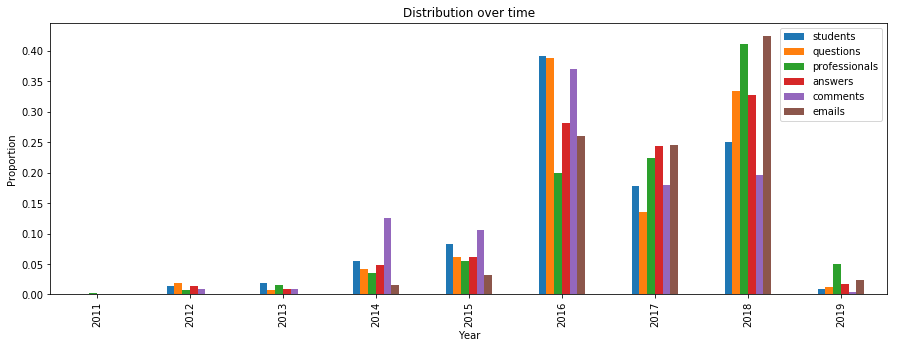

In [175]:
plt_professionals = (professionals.groupby([professionals['professionals_date_joined'].dt.year]).size()/len(professionals.index))
plt_students  = (students.groupby([students['students_date_joined'].dt.year]).size()/len(students.index))
plt_questions = (questions.groupby([questions['questions_date_added'].dt.year]).size()/len(questions.index))
plt_answers   = (answers.groupby([answers['answers_date_added'].dt.year]).size()/len(answers.index))
plt_emails    = (emails.groupby([emails['emails_date_sent'].dt.year]).size()/len(emails.index))
plt_comments  = (comments.groupby([comments['comments_date_added'].dt.year]).size()/len(comments.index))
plt_data      = pd.DataFrame({'students':plt_students,
                              'questions': plt_questions,
                              'professionals':plt_professionals,
                              'answers':plt_answers,
                              'comments':plt_comments,
                              'emails':plt_emails})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Distribution over time')
plt.show()

**First activity after registration**

Here we can see how long it took, that an professional makes his first answer or a student his first question after the registration.
The most of them write the first answer/question within in the first day or haven't write any yet and use the account for other activities.

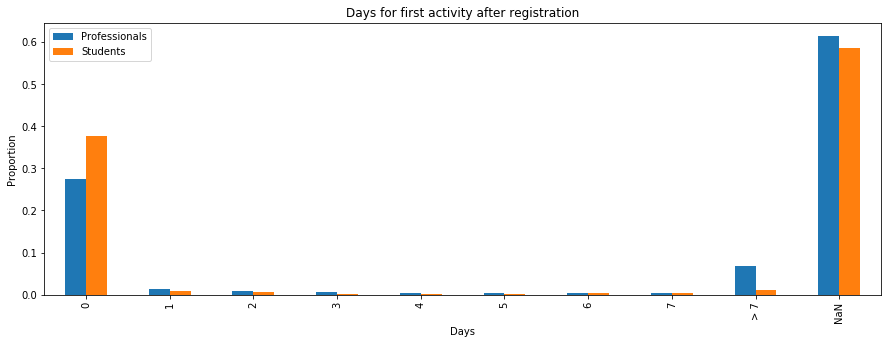

In [178]:
plt_professionals = professionals
plt_professionals = plt_professionals[(plt_professionals['professionals_date_joined'] >= '01-01-2016') & (plt_professionals['professionals_date_joined'] <= '30-06-2018')]
plt_professionals = (plt_professionals['date_first_activity'] - plt_professionals['professionals_date_joined']).dt.days.fillna(9999).astype(int)
plt_professionals = plt_professionals.groupby(plt_professionals).size()/len(plt_professionals.index)
plt_professionals = plt_professionals.rename(lambda x: 0 if x < 0.0 else x)
plt_professionals = plt_professionals.rename(lambda x: x if x <= 7.0 or x == 9999 else '> 7')
plt_professionals = plt_professionals.rename({9999:'NaN'})
plt_professionals = plt_professionals.groupby(level=0).sum()

plt_students = students
plt_students = plt_students[(plt_students['students_date_joined'] >= '01-01-2016') & (plt_students['students_date_joined'] <= '30-06-2018')]
plt_students = (plt_students['date_first_activity'] - plt_students['students_date_joined']).dt.days.fillna(9999).astype(int)
plt_students = plt_students.groupby(plt_students).size()/len(plt_students.index)
plt_students = plt_students.rename(lambda x: 0 if x < 0.0 else x)
plt_students = plt_students.rename(lambda x: x if x <= 7.0 or x == 9999 else '> 7')
plt_students = plt_students.rename({9999:'NaN'})
plt_students = plt_students.groupby(level=0).sum()

plt_data = pd.DataFrame({'Professionals': plt_professionals,
                        'Students': plt_students})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Days')
plt.ylabel('Proportion')
plt.title('Days for first activity after registration')
plt.show()


**Last activity**

Depending on the last comment, question or answer of a user, we have extract the last activity date. On the previously plot we have seen, that many users haven't done any activity yet. For the 'last activity' plot we take a look only on users with already have one activity (dropna).
On the cumulative histogram we can see, that in the last 12 months only 39% of professionals and 24% of students have written a comment, question or answer.
50% of the professionals haven't done any activity for 17 months.

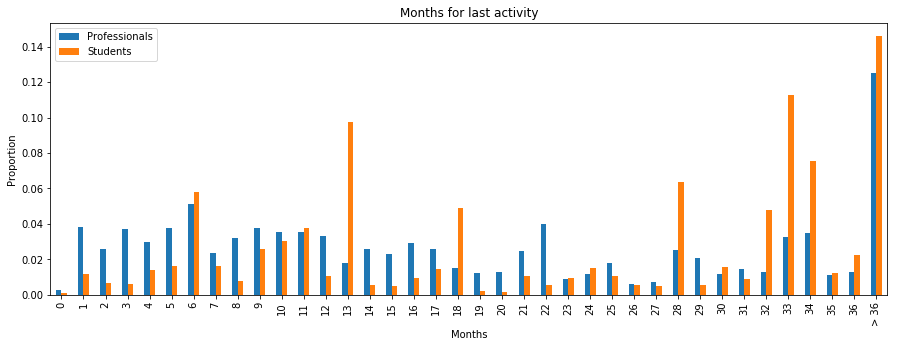

In [179]:
plt_professionals = ((actual_date - professionals['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_professionals = plt_professionals.groupby(plt_professionals).size()/len(plt_professionals.index)
plt_professionals = plt_professionals.rename(lambda x: 0 if x < 0.0 else x)
plt_professionals = plt_professionals.rename(lambda x: x if x <= 36.0 or x == 9999 else '> 36')
plt_professionals = plt_professionals.rename({9999:'NaN'})
plt_professionals = plt_professionals.groupby(level=0).sum()

plt_students = ((actual_date - students['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_students = plt_students.groupby(plt_students).size()/len(plt_students.index)
plt_students = plt_students.rename(lambda x: 0 if x < 0.0 else x)
plt_students = plt_students.rename(lambda x: x if x <= 36.0 or x == 9999 else '> 36')
plt_students = plt_students.rename({9999:'NaN'})
plt_students = plt_students.groupby(level=0).sum()

plt_data = pd.DataFrame({'Professionals': plt_professionals,
                        'Students': plt_students})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Months')
plt.ylabel('Proportion')
plt.title('Months for last activity')
plt.show()

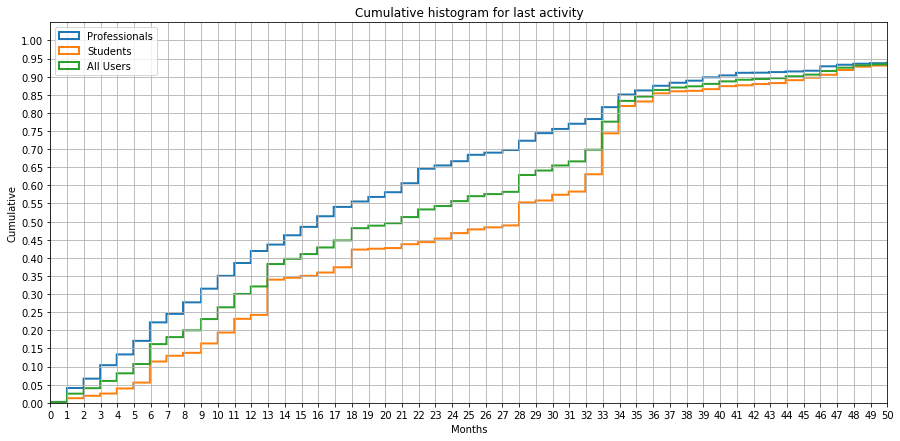

In [180]:
plt_professionals = ((actual_date - professionals['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_students = ((actual_date - students['date_last_activity']).dt.days/30).dropna().apply(lambda x: math.ceil(x)).astype(int)
plt_data = pd.DataFrame({'Professionals': plt_professionals, 'Students': plt_students})
plt_total = pd.concat([plt_data['Professionals'], plt_data['Students']]).rename('All Users')
plt_data.plot(kind='hist', bins=1000, density=True, histtype='step', cumulative=True, figsize=(15, 7), lw=2, grid=True)
plt_total.plot(kind='hist', bins=1000, density=True, histtype='step', cumulative=True, figsize=(15, 7), lw=2, grid=True)
plt.xlabel('Months')
plt.ylabel('Cumulative')
plt.title('Cumulative histogram for last activity')
plt.legend(loc='upper left')
plt.xlim([0, 50])
plt.xticks(range(0, 51, 1))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()


## Questions dataset

In [140]:
#  Let's see what's going on in the `questions` dataframe

print(questions.shape)
questions.head(1)

(23931, 15)


questions_id               questions_author_id  \
0  332a511f1569444485cf7a7a556a5e54  8f6f374ffd834d258ab69d376dd998f5   

  questions_date_added              questions_title  \
0 2016-04-26 11:14:26   Teacher   career   question   

                                                                                     questions_body  \
0  What  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecture   

                                                                                                                   questions_full_text  \
0  Teacher   career   question\r\n\r\nWhat  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecture   

   questions_answers_count questions_first_answers questions_last_answers  \
0  1                       2016-04-29 19:40:14     2016-04-29 19:40:14      

   questions_hearts                 questions_tags  \
0  1                 [lecture, college, professor]   

                                                                                       nlp_tokens  \
0  [teacher, career, question, math, teacher, math, teacher, useful, college, professor, lecture]   

   questions_title_length  questions_body_length  member_in_emails  
0  27                      96                     200.0

A total of 23931 questions have been asked over the years (Sep 2011 to Jan 2019). We look at the numbers year by year, month by month and also monthly average.

In [57]:
num_of_questions = len(set(questions['questions_id']))
print('Total Number Of Questions : {}'.format(num_of_questions))

Total Number Of Questions : 23931


**First answer for questions**

Here we can see how long it takes for a question to get the first answer.
The most questions get answered within the first two weeks. But 15% need more than 30 weeks to get there answer. And there are still some unanswered questions.
The questions are filtered until 30-06-2018 to ignore new unanswered questions.

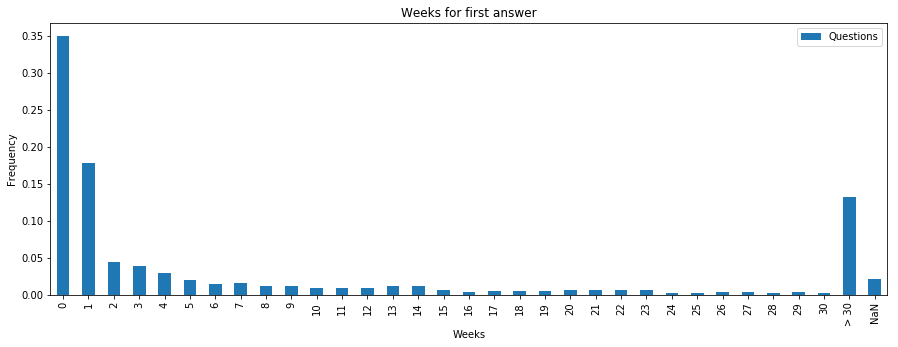

In [181]:
plt_questions = questions
plt_questions = plt_questions[(plt_questions['questions_date_added'] >= '01-01-2016') & (plt_questions['questions_date_added'] <= '30-06-2018')]
plt_questions = ((plt_questions['questions_first_answers'] - plt_questions['questions_date_added']).dt.days/7).fillna(9999).apply(lambda x: math.ceil(x)).astype(int)
plt_questions = plt_questions.groupby(plt_questions).size()/len(plt_questions.index)
plt_questions = plt_questions.rename(lambda x: 0 if x < 0.0 else x)
plt_questions = plt_questions.rename(lambda x: x if x <= 30.0 or x == 9999 else '> 30')
plt_questions = plt_questions.rename({9999:'NaN'})
plt_questions = plt_questions.groupby(level=0).sum()

plt_data = pd.DataFrame({'Questions': plt_questions})
plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Weeks')
plt.ylabel('Frequency')
plt.title('Weeks for first answer')
plt.show()

**Question response time**

It is important for students to get their questions answered quickly. The goal was to get an answer within 24 hours.
The chart shows how many questions were answered in a month within the desired time.
From November 2015 to February 2016 the most questions get a answer within 24 hours. After that it drops and has stronger deviations.

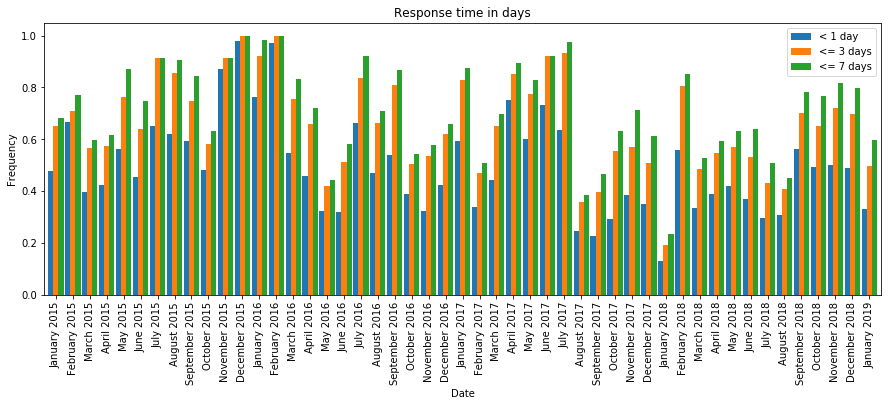

In [182]:
plt_data = questions[['questions_date_added', 'questions_first_answers']]
plt_data = plt_data[plt_data['questions_date_added'] > '2015-01-01']
plt_data['answer_time'] = (plt_data['questions_first_answers'] - plt_data['questions_date_added'])
plt_data['days'] = (plt_data['questions_first_answers'] - plt_data['questions_date_added']).dt.days
plt_data['date'] = plt_data['questions_date_added'].dt.strftime('%B %Y')
plt_data['date'] = plt_data['date'].apply(lambda x: str(datetime.strptime(x, "%B %Y")))  
plt_data['date2'] = plt_data['questions_date_added'].dt.strftime('%B %Y')

plt_data_1 = (plt_data[plt_data['days'] <= 0].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('< 1 day')
plt_data_2 = (plt_data[plt_data['days'] <= 3].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('<= 3 days')
plt_data_3 = (plt_data[plt_data['days'] <= 7].groupby(['date', 'date2']).size() / plt_data.groupby(['date', 'date2']).size()).rename('<= 7 days')
plt_data = pd.concat([plt_data_1, plt_data_2, plt_data_3], axis=1).fillna(0)
plt_data.index = plt_data.index.droplevel('date')

plt_data.plot(kind='bar', figsize=(15, 5), width=0.9)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Response time in days')
plt.show()

### Time Distribution Of Number Of Questions were asked

In [58]:
# questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])
questions_copy = questions.set_index(keys='questions_date_added')

In [60]:
questions_yearly_distibution = questions_copy['questions_id'].groupby([questions_copy.index.year]).count()
questions_month_distibution  = questions_copy['questions_id'].groupby([questions_copy.index.month]).count()

questions_copy['month_year']  = questions_copy.index.to_period('M').astype('str')
questions_monthly_distibution = questions_copy[['month_year', 'questions_id']].groupby(by='month_year').count()

In [64]:
import calendar


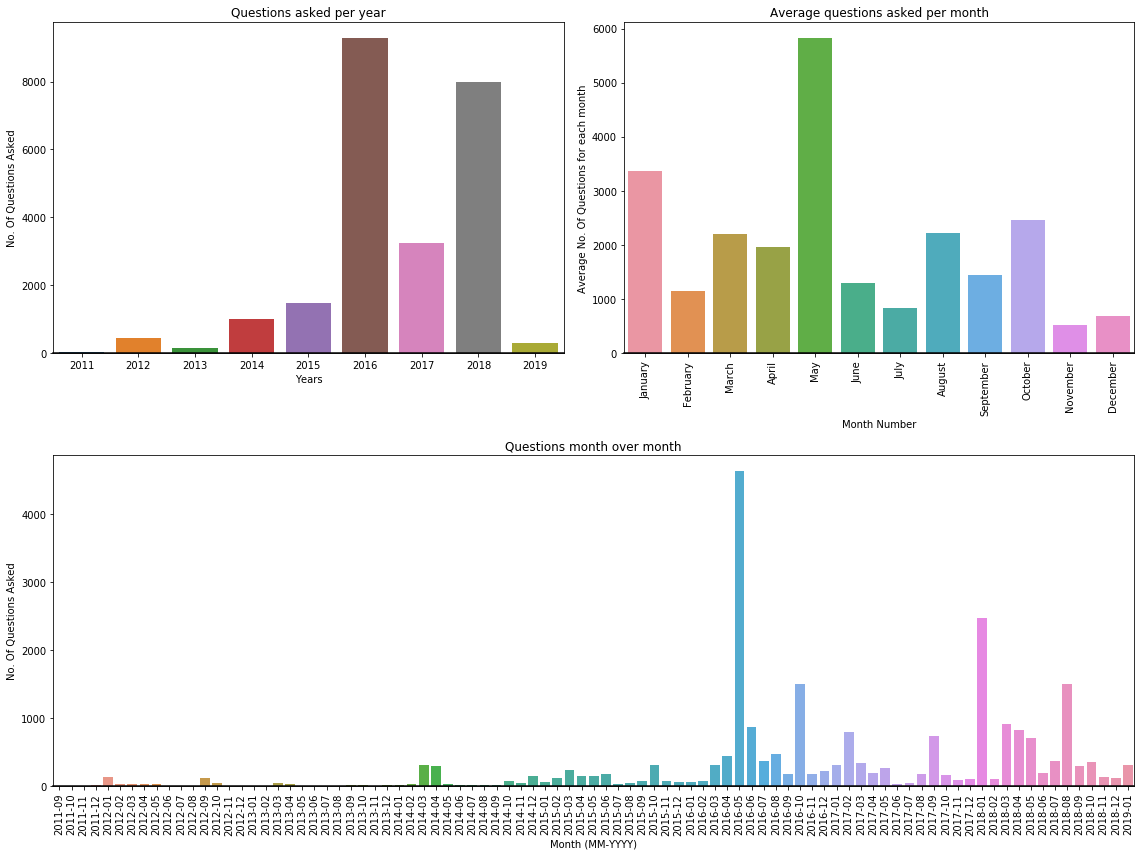

In [67]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

ax1.set_xlabel('Years')
ax2.set_xlabel('Month Number')
ax3.set_xlabel('Month (MM-YYYY)')

ax1.set_ylabel('No. Of Questions Asked')
ax2.set_ylabel('Average No. Of Questions for each month')
ax3.set_ylabel('No. Of Questions Asked')

ax1.set_title('Questions asked per year')
ax2.set_title('Average questions asked per month')
ax3.set_title('Questions month over month')

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

x_ = questions_month_distibution.index.values 
sns.barplot(questions_yearly_distibution.index.values, 
            questions_yearly_distibution.values, 
            ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
sns.barplot([calendar.month_name[m ] for m in x_], 
            questions_month_distibution.values,
            ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
sns.barplot(questions_monthly_distibution.index.values, 
            questions_monthly_distibution.values.ravel(),
            ax=ax3)
ax3.axhline(0, color="k", clip_on=False)

fig.tight_layout()

As can be seen from the above plot, questions peak around May of each year (which matches the college joining time) and also that they peaked in 2016 - showing growing popularity of the platform around 2016.

## Professionals

In [70]:
num_of_professionals = len(set(professionals['professionals_id']))
print(f'Total Number Of Professionals : {num_of_professionals}')

Total Number Of Professionals : 28152


A total of 28k professionals are on the platform with their professions and areas of expertise as diverse as showcased in the image :) We look at the distributions of the industries these professionals belong to, locations and joining dates.

### Missing values (Professionals) 

The Location, Industry and Headline were specified by the most professionals. Even hashtags are used by most. The specification of the school is made however only by the fewest.
The industry could therefore be a good feature for the recommendation. Especially for new authors who have not written any answer or comments. If an professional is in the medical field, he should not necessarily get questions about a career as a lawyer.

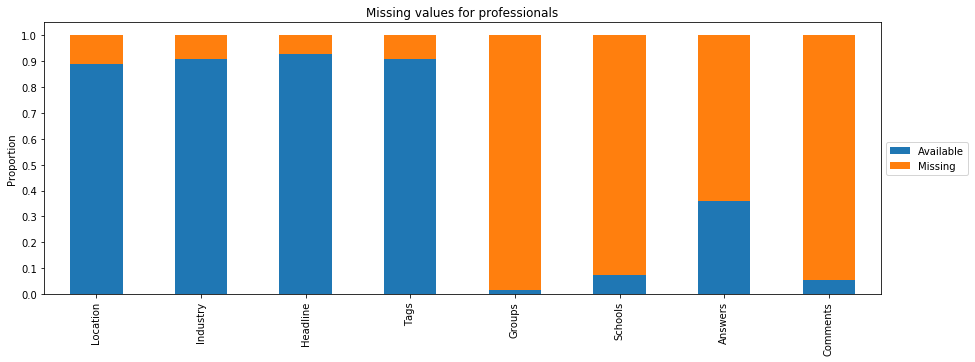

Available   Missing
Location  0.889955   0.110045
Industry  0.908497   0.091503
Headline  0.926577   0.073423
Tags      0.909136   0.090864
Groups    0.017477   0.982523
Schools   0.075341   0.924659
Answers   0.357594   0.642406
Comments  0.052359   0.947641

In [173]:
temp = professionals[['professionals_location', 'professionals_industry', 'professionals_headline']].fillna('Missing')
temp = temp.applymap(lambda x: x if x == 'Missing' else 'Available')
plt_professionals_location = temp.groupby('professionals_location').size()/len(temp.index)
plt_professionals_industry = temp.groupby('professionals_industry').size()/len(temp.index)
plt_professionals_headline = temp.groupby('professionals_headline').size()/len(temp.index)

plt_professionals_tags   = tag_users['tag_users_user_id'].unique()
plt_professionals_tags   = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_tags else 'Missing').rename('professionals_tags')
plt_professionals_tags   = plt_professionals_tags.groupby(plt_professionals_tags).size()/len(plt_professionals_tags.index)
plt_professionals_group  = group_memberships['group_memberships_user_id'].unique()
plt_professionals_group  = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_group else 'Missing').rename('professionals_groups')
plt_professionals_group  = plt_professionals_group.groupby(plt_professionals_group).size()/len(plt_professionals_group.index)
plt_professionals_school = school_memberships['school_memberships_user_id'].unique()
plt_professionals_school = professionals['professionals_id'].apply(lambda x: 'Available' if x in plt_professionals_school else 'Missing').rename('professionals_schools')
plt_professionals_school = plt_professionals_school.groupby(plt_professionals_school).size()/len(plt_professionals_school.index)

temp = professionals[['professionals_answers_count', 'professionals_comments_count']]
temp = temp.applymap(lambda x: 'Available' if x > 0 else 'Missing')
plt_professionals_answers  = temp.groupby('professionals_answers_count').size()/len(temp.index)
plt_professionals_comments = temp.groupby('professionals_comments_count').size()/len(temp.index)

plt_data = pd.DataFrame({'Location': plt_professionals_location,
                        'Industry': plt_professionals_industry,
                        'Headline': plt_professionals_headline,
                        'Tags': plt_professionals_tags,
                        'Groups': plt_professionals_group,
                        'Schools': plt_professionals_school,
                        'Answers': plt_professionals_answers,
                        'Comments': plt_professionals_comments,})

plt_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for professionals')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_data.T


### Distribution of professionals by industry and location

In [72]:
TOP_NUM = 30 

In [73]:
professionals['professionals_industry'] = professionals[~pd.isnull(professionals['professionals_industry'])]['professionals_industry'].astype(str)
professionals_industry = professionals['professionals_industry'].value_counts().sort_values(ascending=False)

professionals['professionals_location'] = professionals[~pd.isnull(professionals['professionals_location'])]['professionals_location'].astype(str)
professionals_location = professionals['professionals_location'].value_counts().sort_values(ascending=False)

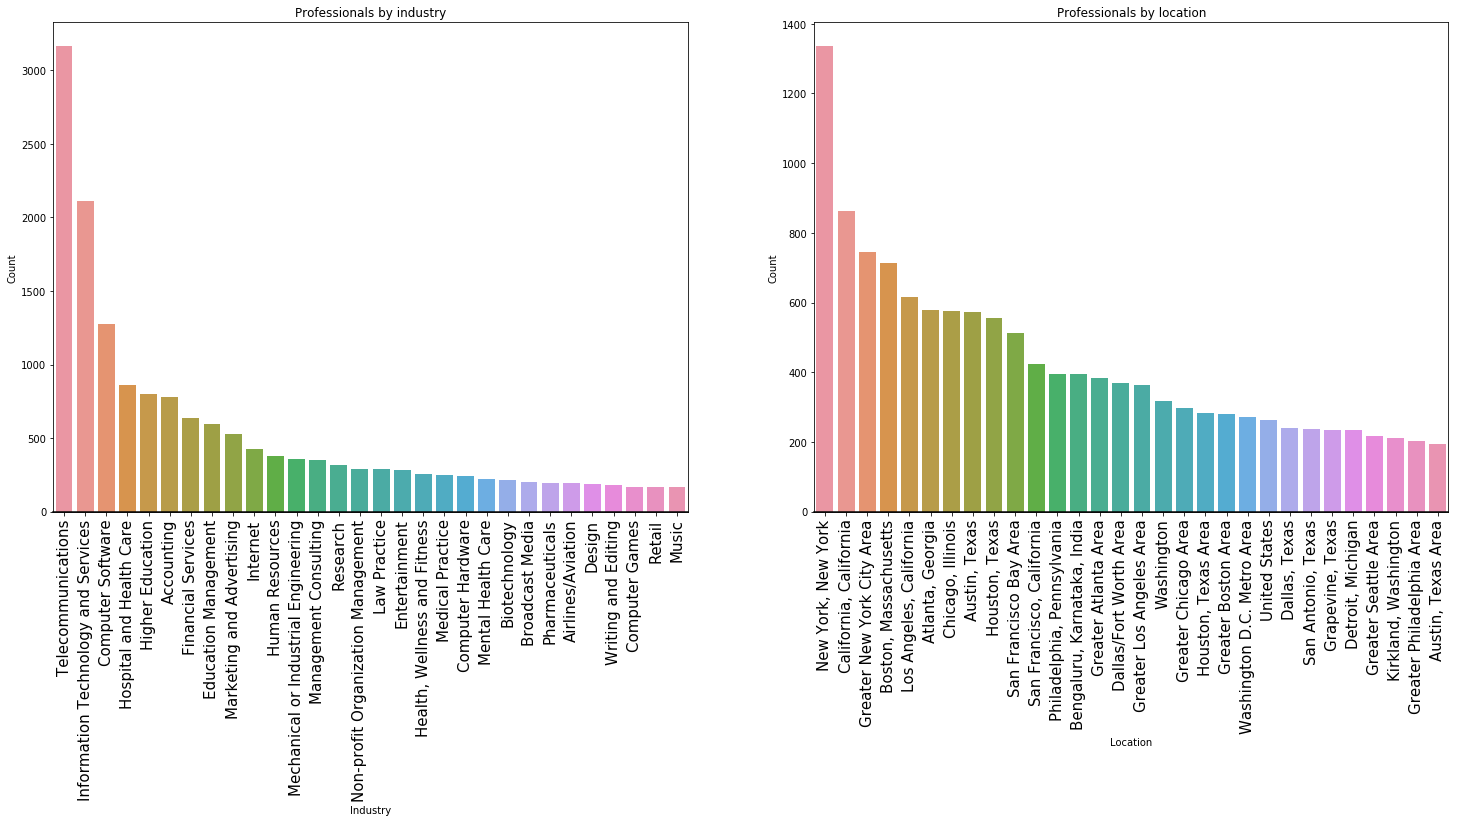

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(25, 9))
sns.barplot(professionals_industry.index.values[:TOP_NUM], 
            professionals_industry.values[:TOP_NUM],
            ax=ax[0])

sns.barplot(professionals_location.index.values[:TOP_NUM], 
            professionals_location.values[:TOP_NUM],
            ax=ax[1])

ax[0].set_title('Professionals by industry')
ax[1].set_title('Professionals by location')

ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')

ax[0].set_xlabel('Industry')
ax[1].set_xlabel('Location')

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, fontsize=15);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, fontsize=15);

ax[0].axhline(0, color="k", clip_on=False)
ax[1].axhline(0, color="k", clip_on=False)

### Time Distribution Of Number Of Professionals who joined

In [75]:
# professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'])
professionals_copy = professionals.set_index(keys='professionals_date_joined')

In [76]:
professionals_yearly_distibution = professionals_copy['professionals_id'].groupby([professionals_copy.index.year]).count()
professionals_month_distibution = professionals_copy['professionals_id'].groupby([professionals_copy.index.month]).count()

professionals_copy['month_year'] = professionals_copy.index.to_period('M').astype('str')
professionals_monthly_distibution = professionals_copy[['month_year', 'professionals_id']].groupby(by='month_year').count()

x = professionals_month_distibution.index.values

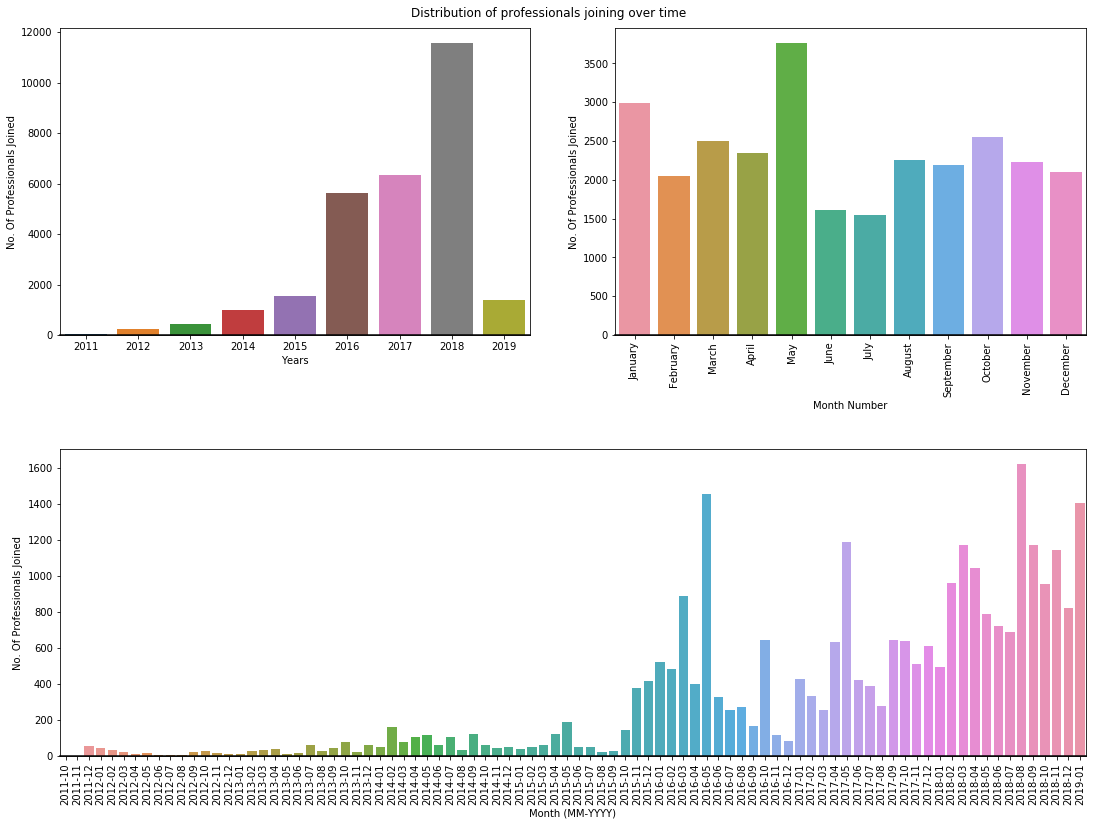

In [77]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

ax1.set_xlabel('Years')
ax2.set_xlabel('Month Number')
ax3.set_xlabel('Month (MM-YYYY)')

ax1.set_ylabel('No. Of Professionals Joined')
ax2.set_ylabel('No. Of Professionals Joined')
ax3.set_ylabel('No. Of Professionals Joined')

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)

sns.barplot(professionals_yearly_distibution.index.values, 
            professionals_yearly_distibution.values,
            ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
sns.barplot([calendar.month_name[m] for m in x], 
            professionals_month_distibution.values,
            ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
sns.barplot(professionals_monthly_distibution.index.values, 
            professionals_monthly_distibution.values.ravel(),
            ax=ax3);
ax3.axhline(0, color="k", clip_on=False)

fig.suptitle('Distribution of professionals joining over time');

fig.tight_layout(pad=3.5)

The growing popularity of the platform and the increasing number of professionals joining in are evident from the yearwise distribution of number of professionals joining in.

## E mails and matches 

In [78]:
email_matches = emails.merge(matches, left_on='emails_id', right_on='matches_email_id', how='outer')
email_matches = email_matches.drop('matches_email_id', axis=1)
email_matches = email_matches.rename({'emails_id' : 'email_id'}, axis=1)

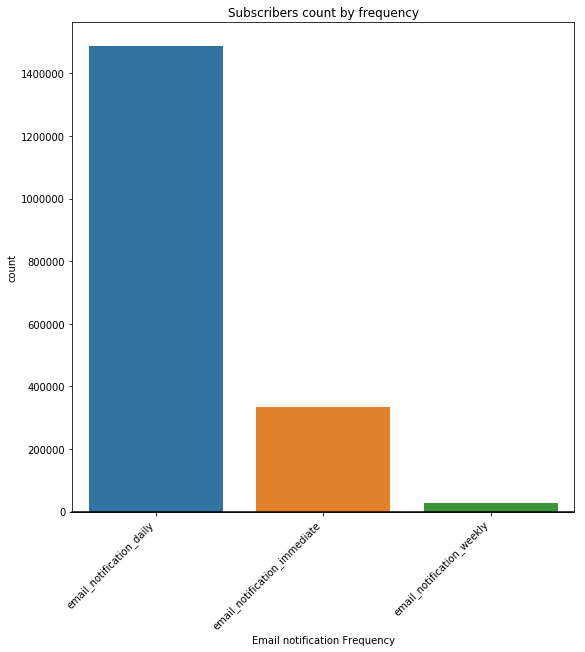

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

sns.countplot(x='emails_frequency_level', data=emails, ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('Email notification Frequency');
ax.set_title('Subscribers count by frequency')
ax.axhline(0, color="k", clip_on=False)

### Number of questions per email

Below we show the number of questions per email sent to subscribers with different subscription frequencies.

In [83]:
# question_count_in_email = email_matches.groupby(['email_id', 'emails_frequency_level']).count()['matches_question_id']
question_count_in_email = question_count_in_email.swaplevel(1, 0)

In [84]:
print('Immediate mailing subscription: \n')
print(question_count_in_email.xs('email_notification_immediate').value_counts()[:5])

Immediate mailing subscription: 

1    322193
0    10990 
Name: matches_question_id, dtype: int64


In [85]:
print('Daily mailing subscription: \n')
print(question_count_in_email.xs('email_notification_daily').value_counts()[:5])

Daily mailing subscription: 

3    984944
1    318243
2    123694
0    44650 
4    4351  
Name: matches_question_id, dtype: int64


In [86]:
print('Weekly mailing subscription: \n')
print(question_count_in_email.xs('email_notification_weekly').value_counts()[:5])

Weekly mailing subscription: 

19    12249
1     4611 
2     2488 
3     1737 
4     1184 
Name: matches_question_id, dtype: int64


Observations:

    - 19 questions sent to weekly subscribers
    - 3 questions sent to daily subscribers
    - 1 question sent to immediate subscribers

Text(0, 0.5, '# questions')

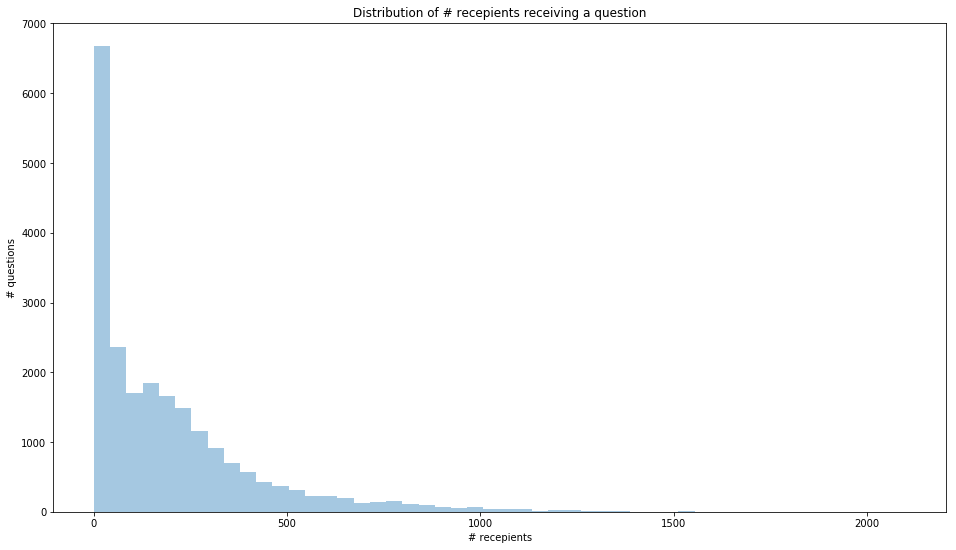

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
matches_count = email_matches.groupby('matches_question_id').count()['email_id']
sns.distplot(matches_count.values, kde=False, norm_hist=False)
ax.set_title('Distribution of # recepients receiving a question')
ax.set_xlabel('# recepients')
ax.set_ylabel('# questions')

## ETA in answering

In [89]:
question_sent = matches.groupby('matches_question_id', as_index=False).count()
question_sent = question_sent.rename({'matches_email_id' : 'member_in_emails'}, axis=1)

In [90]:
questions['questions_title_length'] = questions['questions_title'].apply(len)
questions['questions_body_length']  = questions['questions_body'].apply(len)

questions = questions.merge(question_sent, left_on='questions_id', 
                                  right_on='matches_question_id', how='left')
questions = questions.drop(['matches_question_id'], axis=1)

questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'])



In [91]:
questions_indexed = questions.set_index(keys='questions_date_added')
answers_indexed   = answers.set_index(  keys='answers_date_added')

answers_indexed = answers_indexed.drop_duplicates(subset='answers_question_id', keep='first')
questions_yearly_distibution = questions_indexed['questions_id'].groupby([questions_indexed.index.year]).count()
answers_yearly_distibution   = answers_indexed['answers_question_id'].groupby([answers_indexed.index.year]).count()

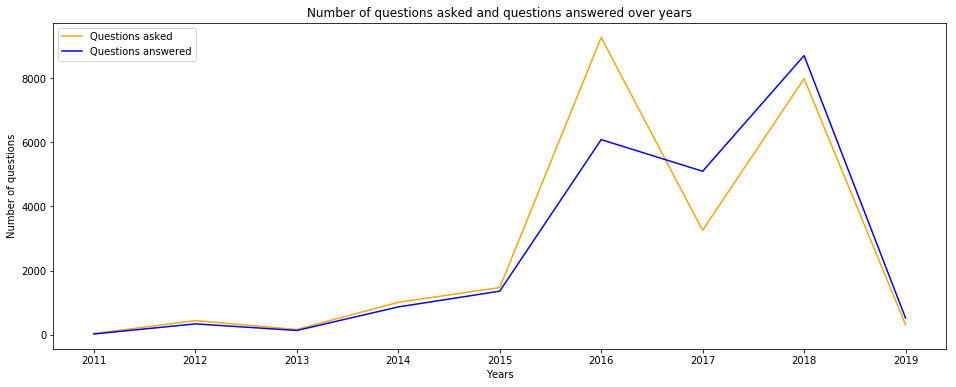

In [92]:
plt.figure(figsize=[16,6])
plt.plot(questions_yearly_distibution.values, color='orange')
plt.plot(answers_yearly_distibution.values, color='blue')
plt.xticks(range(len(questions_yearly_distibution.index.values)), questions_yearly_distibution.index.values);
plt.title("Number of questions asked and questions answered over years");
plt.xlabel("Years");
plt.ylabel("Number of questions");
plt.legend(['Questions asked','Questions answered'], loc=0);

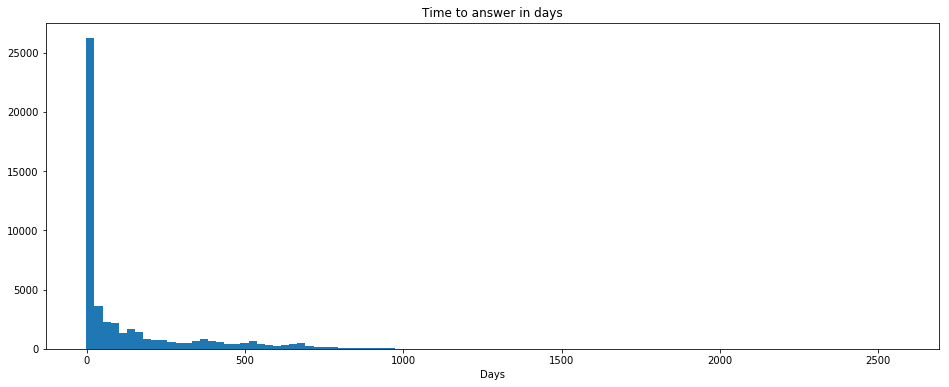

In [93]:
questions_answers = questions.merge(answers, left_on='questions_id', right_on='answers_question_id', how='inner')
questions_answers_copy = questions_answers[['questions_id', 'questions_date_added', 'answers_date_added', 
                                                  'questions_title_length', 'questions_body_length', 'member_in_emails']]

questions_answers_copy['time_to_answer'] = questions_answers_copy['answers_date_added'] - questions_answers_copy['questions_date_added']
questions_answers_copy['time_to_answer_in_days'] = questions_answers_copy['time_to_answer'].dt.days

plt.figure(figsize=[16,6])
plt.hist(questions_answers_copy['time_to_answer_in_days'].values, bins=100);
plt.xlabel('Days')
plt.title('Time to answer in days');

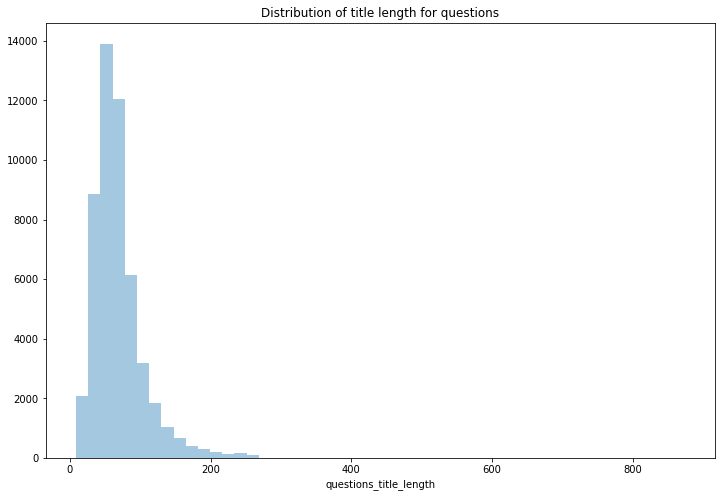

In [94]:
plt.figure(figsize=[12,8])
sns.distplot(questions_answers_copy['questions_title_length'], kde=False, norm_hist=False)
plt.title('Distribution of title length for questions');

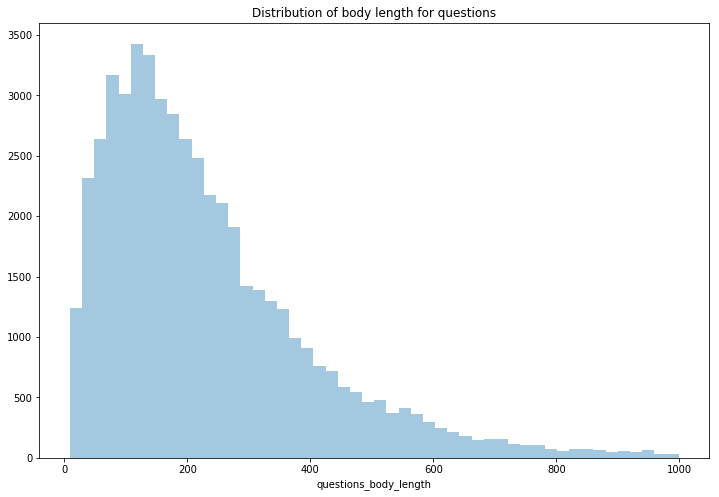

In [95]:
plt.figure(figsize=[12,8])
sns.distplot(questions_answers_copy[questions_answers_copy['questions_body_length']<1000]['questions_body_length'], kde=False, norm_hist=False, bins=50)
plt.title('Distribution of body length for questions');

In [96]:
questions_answers_copy[['questions_title_length', 'questions_body_length', 'time_to_answer_in_days']].corr()

questions_title_length  questions_body_length  \
questions_title_length  1.000000                0.098629                
questions_body_length   0.098629                1.000000                
time_to_answer_in_days -0.006594               -0.030917                

                        time_to_answer_in_days  
questions_title_length -0.006594                
questions_body_length  -0.030917                
time_to_answer_in_days  1.000000

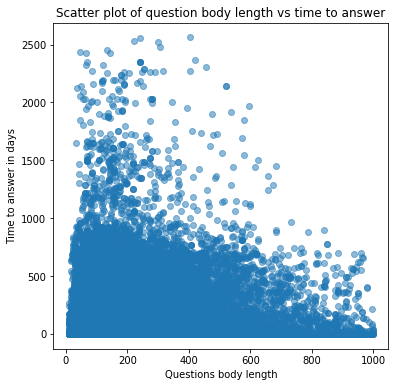

In [98]:
questions_answers_copy_1 = questions_answers_copy[questions_answers_copy['questions_body_length'] < 1000]

plt.figure(figsize=[6,6])
plt.scatter(questions_answers_copy_1['questions_body_length'], questions_answers_copy_1['time_to_answer_in_days'], alpha=0.5)
plt.title('Scatter plot of question body length vs time to answer');
plt.xlabel('Questions body length');
plt.ylabel('Time to answer in days');

As can be seen, there is very little correlation between the length of questions body and the time it takes to answer the question in days.

In [99]:
questions_answers_copy[['member_in_emails', 'time_to_answer_in_days']].corr()

member_in_emails  time_to_answer_in_days
member_in_emails        1.000000          0.071683              
time_to_answer_in_days  0.071683          1.000000

## Answers

In [102]:
num_of_answers = len(set(answers['answers_id']))
print(f'Total Number Of answers            : {num_of_answers}')

num_of_questions = len(set(answers['answers_question_id']))
print(f'Total Number Of Questions answered : {num_of_questions}')

Total Number Of answers            : 51123
Total Number Of Questions answered : 23110


In [141]:
# our data description lets us know that "Answers are what this is all about! Answers get posted in response to questions. Answers can only be posted by users who are registered as Professionals." 
# So, let's check out our `answers` data followed by our `professionals` data
answers.head(1)

answers_id                 answers_author_id  \
0  4e5f01128cae4f6d8fd697cec5dca60c  36ff3b3666df400f956f8335cf53e09e   

                answers_question_id  answers_date_added  \
0  332a511f1569444485cf7a7a556a5e54 2016-04-29 19:40:14   

                                                                                                                                                                                                                                                                                                                                  answers_body  \
0  <p>Hi!</p>\n<p>You are asking a very interesting question.  I am giving you two sites that will give you some of an explanation that may answer your question.</p>\n<p>http://mathforum.org/dr.math/faq/faq.why.math.html</p>\n<p>http://www.mathworksheetscenter.com/mathtips/mathissoimportant.html</p>\n<p>Let me know if this helps</p>   

  time_delta_answer  answers_time_rank  answers_hearts  
0 3 days 08:25:48    1                  0

### Missing values (Students)

It's a little different with the students. Only the location is specified by most students, while the rest is rather not used.

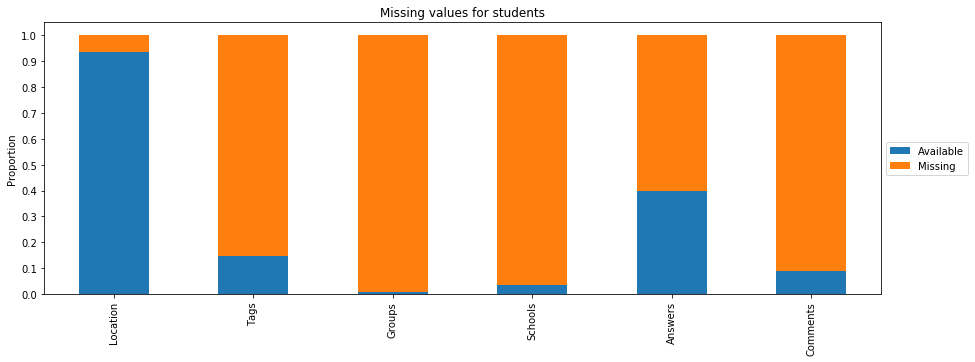

Available   Missing
Location  0.934358   0.065642
Tags      0.148784   0.851216
Groups    0.007588   0.992412
Schools   0.034226   0.965774
Answers   0.397275   0.602725
Comments  0.087921   0.912079

In [174]:
temp = students[['students_location']].fillna('Missing')
temp = temp.applymap(lambda x: x if x == 'Missing' else 'Available')
plt_students_location = temp.groupby('students_location').size()/len(temp.index)

plt_students_tags = tag_users['tag_users_user_id'].unique()
plt_students_tags = students['students_id'].apply(lambda x: 'Available' if x in plt_students_tags else 'Missing').rename('students_tags')
plt_students_tags = plt_students_tags.groupby(plt_students_tags).size()/len(plt_students_tags.index)
plt_students_group = group_memberships['group_memberships_user_id'].unique()
plt_students_group = students['students_id'].apply(lambda x: 'Available' if x in plt_students_group else 'Missing').rename('students_groups')
plt_students_group = plt_students_group.groupby(plt_students_group).size()/len(plt_students_group.index)
plt_students_school = school_memberships['school_memberships_user_id'].unique()
plt_students_school = students['students_id'].apply(lambda x: 'Available' if x in plt_students_school else 'Missing').rename('students_schools')
plt_students_school = plt_students_school.groupby(plt_students_school).size()/len(plt_students_school.index)

temp = students[['students_questions_count', 'students_comments_count']]
temp = temp.applymap(lambda x: 'Available' if x > 0 else 'Missing')
plt_students_questions = temp.groupby('students_questions_count').size()/len(temp.index)
plt_students_comments = temp.groupby('students_comments_count').size()/len(temp.index)

plt_data = pd.DataFrame({'Location': plt_students_location,
                        'Tags': plt_students_tags,
                        'Groups': plt_students_group,
                        'Schools': plt_students_school,
                        'Answers': plt_students_questions,
                        'Comments': plt_students_comments,})

plt_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for students')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_data.T 

In [104]:
tag_question = tag_questions.merge(right=tags, how="left", left_on="tag_questions_tag_id", right_on="tags_tag_id")
mapping = dict(tag_question[['tag_questions_question_id', 'tags_tag_name']].values)
answer  = answers.copy()
answer['tag_name'] = answers.answers_question_id.map(mapping)

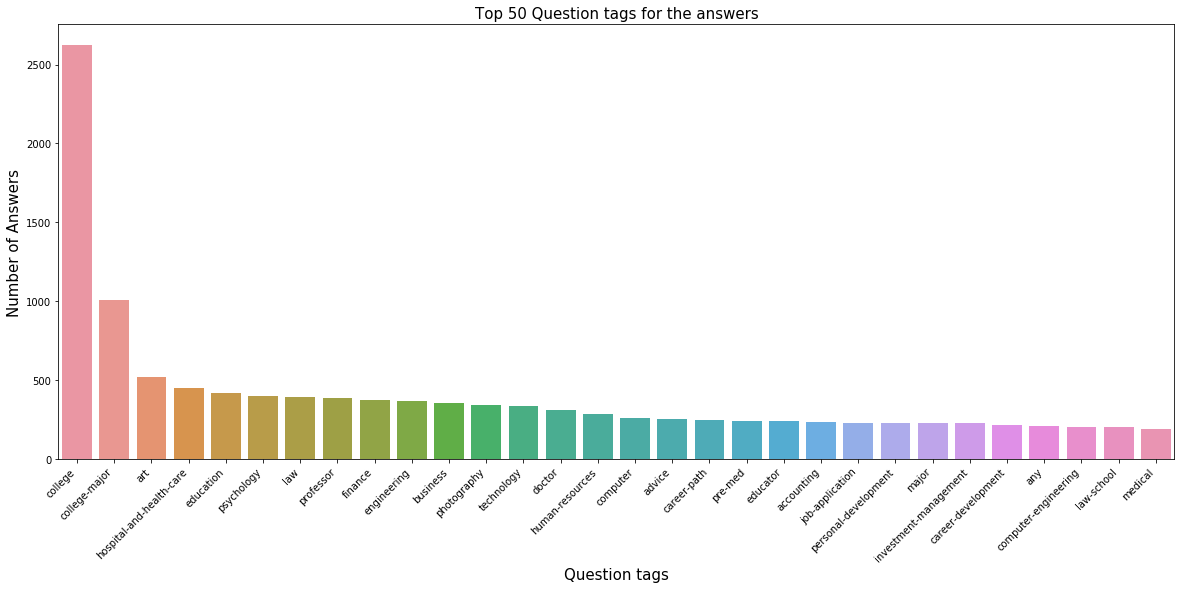

In [105]:
answers_tags = answer.tag_name.value_counts().sort_values(ascending=True).tail(30).sort_values(ascending=False)
plt.figure(figsize=[20,8])
ax = sns.barplot(x = answers_tags.index.values, y= answers_tags.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# df_answers_tags.plot.barh(figsize=(10, 8),  width=1)
plt.title("Top 50 Question tags for the answers", fontsize=15)
plt.ylabel('Number of Answers', fontsize=15)
plt.xlabel('Question tags', fontsize=15)
plt.show()

### Length of answer body

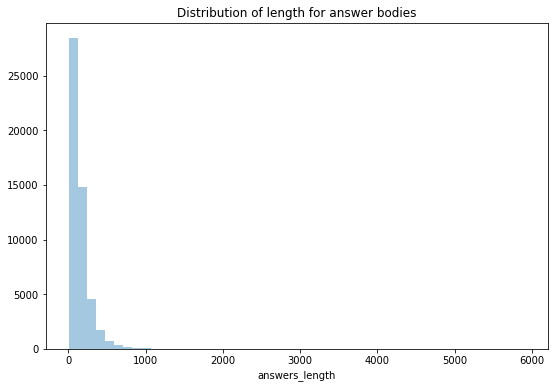

In [106]:
answer['answers_length'] = answer['answers_body'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=[9,6])
sns.distplot(answer['answers_length'], kde=False, norm_hist=False)
plt.title('Distribution of length for answer bodies');

### Number of Answers for Questions

Text(0.5, 0, '# answers')

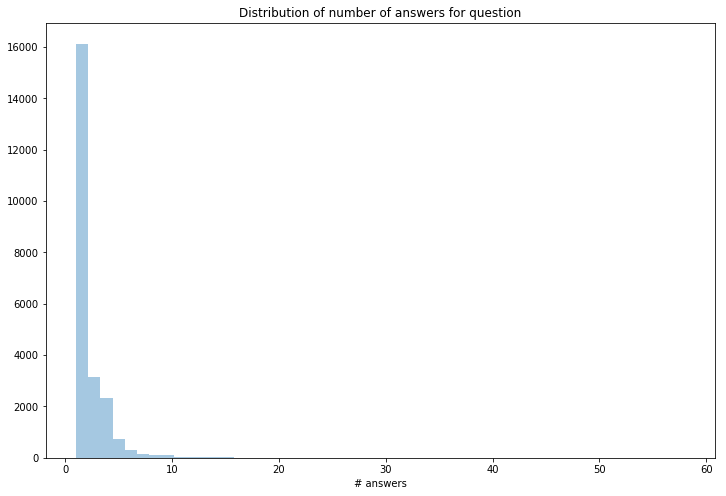

In [107]:
number_answers_for_question = answers['answers_question_id'].value_counts(ascending=True).values

plt.figure(figsize=[12,8])
sns.distplot(number_answers_for_question, kde=False, norm_hist=False)
plt.title('Distribution of number of answers for question');
plt.xlabel('# answers')

## Comments

In [109]:
print(f'There are {comments.shape[0]} total comments')
print('Comments by {} unique authors'.format(np.unique(comments['comments_author_id']).shape[0]))

There are 14966 total comments
Comments by 4231 unique authors


In [110]:
comments['is_author_prof']    = comments['comments_author_id'].isin(list(professionals['professionals_id']))
comments['is_author_student'] = comments['comments_author_id'].isin(list(students['students_id']))
comments['is_author_other_user'] = np.logical_not(np.logical_or(comments['is_author_prof'], comments['is_author_student']))

print('Number of comments by professionals: {}'.format(sum(comments['is_author_prof'])))
print('Number of comments by students: {}'.format(sum(comments['is_author_student'])))
print('Number of comments by other users: {}'.format(sum(comments['is_author_other_user'])))

Number of comments by professionals: 3395
Number of comments by students: 10962
Number of comments by other users: 609


In [111]:
comments['is_parent_question'] = comments['comments_parent_content_id'].isin(list(questions['questions_id']))
comments['is_parent_answer']   = comments['comments_parent_content_id'].isin(list(answers['answers_id']))

print('Number of comments on questions: {}'.format(sum(comments['is_parent_question'])))
print('Number of comments on answers: {}'.format(sum(comments['is_parent_answer'])))

Number of comments on questions: 2388
Number of comments on answers: 12578


In [112]:
comments_body = comments['comments_body']

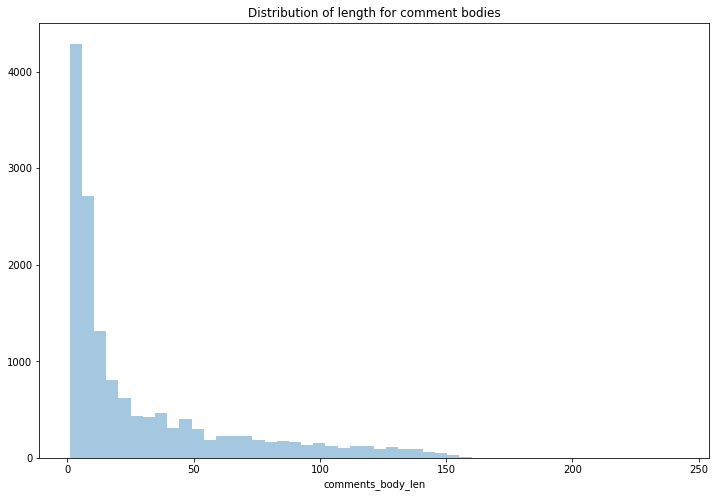

In [114]:
def f(txt):
    return len(str(txt).split(" "))
    
comments['comments_body_len'] = comments['comments_body'].apply(f)

plt.figure(figsize=[12,8])
sns.distplot(comments['comments_body_len'], kde=False, norm_hist=False)
plt.title('Distribution of length for comment bodies');

In [115]:
has_thank_index = ['thank' in str(a).lower() for a in comments_body]
print("Number of comments with string 'thank': "+str(sum(has_thank_index)))
has_thank_comments = comments[has_thank_index]
has_thank_comments['comments_body'].head()

Number of comments with string 'thank': 8759


4     Thank you. I'm new to this site. I'm sorry if what I put out there is spam. I will for sure read through those forums.                                                                                                                                                                                                                                                                      
8     Thanks so much for your answer, Bryant and will start thinking about what you told me. You really helped me                                                                                                                                                                                                                                                                                 
23    Thank you, this is a really helpful answer! I will definitely try some of the suggestions you've given me; I've never thought of doing those before. Thank you again for the advice!                                        

In [116]:
has_html_index = ['<html>' in str(a).lower() for a in comments_body]
print("Number of comments with string '<html>': "+str(sum(has_html_index)))
has_html_comments = comments[has_html_index]
has_html_comments['comments_body'].head()

Number of comments with string '<html>': 34


14784    <html><head></head><body>I have a website on <a href="http://civilengineersforum.com" rel="nofollow" title="Civil engineering website">civil engineering</a> &amp; i would like to make it one of the top civil engineering website on the web beside my regular 9-5 job. You can visit my <a href="http://civilengineersforum.com" rel="nofollow" title="Civil engineering blog">civil engineering blog</a> here. . . :)</body></html>                                                                                                                                                                                                                                                    
14785    <html><head></head><body>I have a website on <a href="http://civilengineersforum.com" rel="nofollow" title="Civil engineering website">civil engineering</a> &amp; i would like to make it one of the top civil engineering website on the web beside my regular 9-5 job. You can visit my <a href="http://civilengineersf

In [117]:
short_thank_you_comments_index = np.logical_and(comments['comments_body_len']<10, has_thank_index)
short_thank_you_comments = comments[short_thank_you_comments_index]
print("Number of short comments with string 'thank' in them: {}".format(short_thank_you_comments.shape[0]))
short_thank_you_comments['comments_body'].tail()

Number of short comments with string 'thank' in them: 5284


14875    Thank you!                                    
14876    Thank you!                                    
14878    Thank you for answering my question!          
14922    Thank you very much it is greatly appreciated!
14923    Thank you very much it is greatly appreciated!
Name: comments_body, dtype: object

In [118]:
long_comments_index = np.logical_not(short_thank_you_comments_index)
long_comments = comments[long_comments_index]
print("Number of long comments to be analysed further: {}".format(long_comments.shape[0]))
long_comments['comments_body'].head()

Number of long comments to be analysed further: 9682


0    First, you speak to recruiters. They are trained and knowledgable on all the requirements for each branch of service and can do the research for you on the specific job that you are looking at. \r\n\r\nAdditionally, birds of a feather do flock together. In high school, you can join groups like the Civil Air Patrol. The Civil Air Patrol is the auxiliary of the Air Force and many former and retired Air Force member within their ranks.                                                                                                                                                                                                                                                                                                                                                     
1    Most large universities offer study abroad programs.  The study abroad programs are found on the schools website.  You may have to click into the Undergraduate or Graduate links.   I also recommend reaching out t

## Tags

**Tags matching**

The size of the bubbles depends on how many students have subscribe the tag. The x-axis is how many professionals have subscribe the tag and the y-axis is in how many questions the tag is used.
The top tag for professionals ist telecommunications on the right site with about 11% but the tag doesn't appear in many questions or students subscribtion.
The top tags for questions is college with 15.6% and carrer with 6.5%. The other top tags are carrer specific (medicine, engineering, business, ...).
The top tag for students is college but only 1.5% of the students have subscribe this tag.

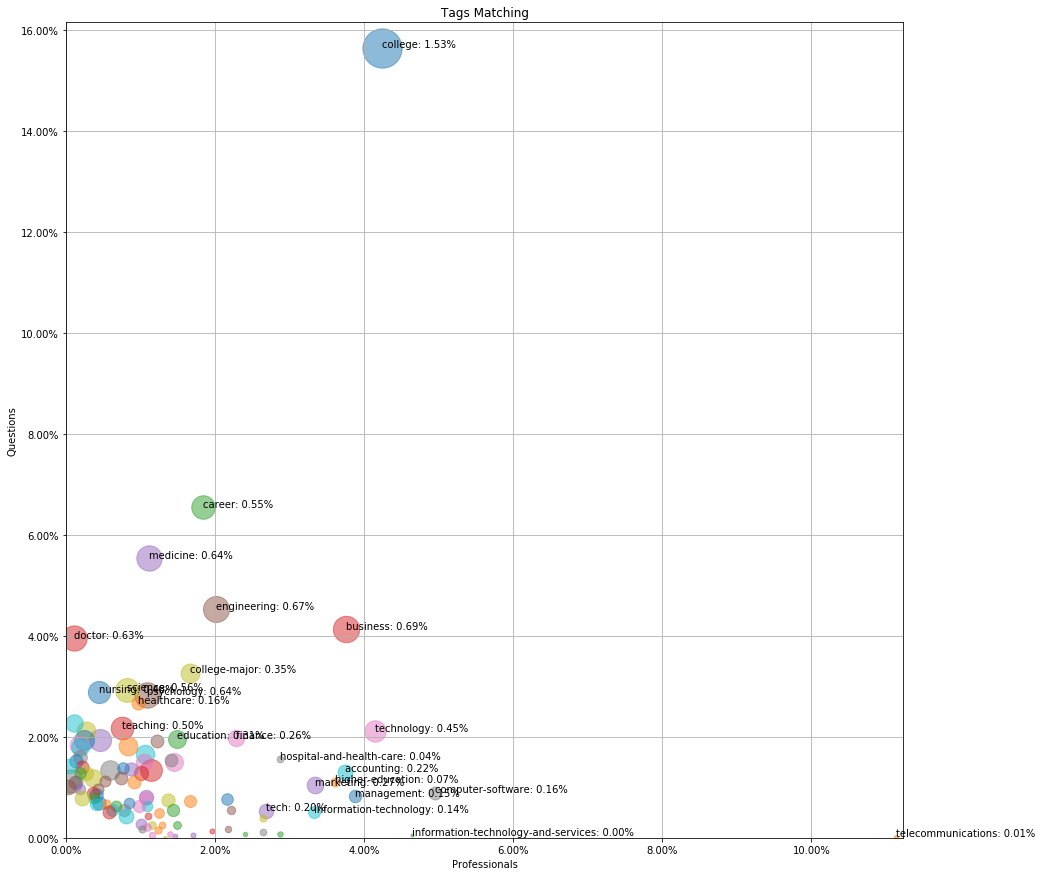

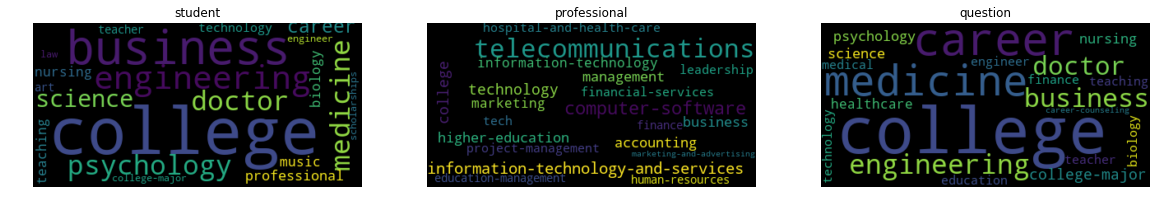

In [177]:
students_tags = tag_users[tag_users['tag_users_user_id'].isin(students['students_id'])]
students_tags = pd.merge(students_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
students_tags['user_type'] = 'student'

professionals_tags = tag_users[tag_users['tag_users_user_id'].isin(professionals['professionals_id'])]
professionals_tags = pd.merge(professionals_tags, tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
professionals_tags['user_type'] = 'professional'

questions_tags = tag_questions
questions_tags = pd.merge(questions_tags, tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
questions_tags['user_type'] = 'question'

plt_data = pd.concat([students_tags, professionals_tags, questions_tags])
plt_data = plt_data[['tags_tag_name', 'user_type']].pivot_table(index='tags_tag_name', columns='user_type', aggfunc=len, fill_value=0)
plt_data['professional'] = plt_data['professional'] / professionals.shape[0]
plt_data['student'] = plt_data['student'] / students.shape[0]
plt_data['question'] = plt_data['question'] / questions.shape[0]
plt_data['sum'] = (plt_data['professional'] + plt_data['student'] + plt_data['question'])
plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)

# Bubble chart
fig, ax = plt.subplots(facecolor='w',figsize=(15, 15))
ax.set_xlabel('Professionals')
ax.set_ylabel('Questions')
ax.set_title('Tags Matching')
ax.set_xlim([0, max(plt_data['professional'])+0.001])
ax.set_ylim([0, max(plt_data['question'])+0.005])
import matplotlib.ticker as mtick
ax.xaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.yaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.grid(True)
i = 0
for key, row in plt_data.iterrows():
    ax.scatter(row['professional'], row['question'], s=10+row['student']*10**5, alpha=.5)
    if i < 25:
        ax.annotate('{}: {:.2%}'.format(key, row['student']), xy=(row['professional'], row['question']))
    i += 1
plt.show()

# Wordcloud
plt.figure(figsize=(20, 20))
wordloud_values = ['student', 'professional', 'question']
axisNum = 1
for wordcloud_value in wordloud_values:
    wordcloud = WordCloud(margin=0, max_words=20, random_state=13).generate_from_frequencies(plt_data[wordcloud_value])
    ax = plt.subplot(1, 3, axisNum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum += 1
plt.show()    

In [119]:
num_unique_users = len(np.unique(tag_users[['tag_users_user_id']])) 
num_unique_tags = tags.shape[0]

print('There are {} unique tags'.format(num_unique_tags))
print('In all {} tags have been given to {} unique users'.format(tag_users.shape[0], num_unique_users))

There are 16269 unique tags
In all 136663 tags have been given to 30202 unique users


In [120]:
count_tags_per_user = tag_users.groupby('tag_users_user_id').count()

In [128]:
import plotly.graph_objs as go

import matplotlib.pyplot as plt

import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot 

In [129]:
data = [go.Histogram(x=count_tags_per_user.values[:,0], opacity=0.75)]
layout = go.Layout(
    title='Distribution of tags per user',
    xaxis=dict(
        title='# tags'
    ),
    yaxis=dict(
        title='# Users'
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [130]:
count_tags_per_user.values.shape

(30202, 1)

In [131]:
count = tag_users.groupby('tag_users_tag_id').count()
count = count.sort_values(by='tag_users_user_id').reset_index()
count = count.rename({'tag_users_user_id':'count'}, axis=1)
tags_users_merged = count.merge(tags, right_on='tags_tag_id', left_on='tag_users_tag_id')
tags_users_merged = tags_users_merged.drop(['tags_tag_id', 'tag_users_tag_id'], axis=1)
tags_users_merged.sort_values(by='count', ascending=False).head(20)
tags_users_merged_sorted = tags_users_merged.sort_values(by='count', ascending=False)

data = [go.Bar(
            y=tags_users_merged_sorted['count'][:TOP_NUM],
            x=tags_users_merged_sorted['tags_tag_name'][:TOP_NUM], opacity=0.75
)]

layout = dict(
    width = 800,
    height = 550,
    title = '30 most common tags overall',
    xaxis = dict(
         tickangle=315,tickfont = dict(size=13,  color='grey'),
    ),
    yaxis = go.layout.YAxis(
        title = '# Users',
        automargin = True,
        titlefont = dict(size=17, color='grey')
    ),
    margin=dict(b=130)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [132]:
all_tagged_users = set(tag_users['tag_users_user_id'])
student_users = set(students['students_id']) 
professional_users = set(professionals['professionals_id'])

tagged_students = all_tagged_users.intersection(student_users)
tagged_professionals = all_tagged_users.intersection(professional_users)
print('Of the {} tagged users, {} are students and {} are professionals'.format(len(all_tagged_users),
                                                                               len(tagged_students),
                                                                               len(tagged_professionals)))

Of the 30202 tagged users, 4608 are students and 25594 are professionals


In [134]:
student_users = tag_users.merge(students, left_on='tag_users_user_id', right_on='students_id')
student_users = student_users.drop('tag_users_user_id', axis=1)
student_users.shape
professional_users = tag_users.merge(professionals, left_on='tag_users_user_id', right_on='professionals_id')
professional_users = professional_users.drop('tag_users_user_id', axis=1)
professional_users.shape
print('In all {} tags have been given to  {} to students and {} to professionals'.format(tag_users.shape[0], 
                                                                 student_users.shape[0], 
                                                                 professional_users.shape[0]))

In all 136663 tags have been given to  19205 to students and 117458 to professionals


In [136]:
count = student_users[['students_id', 'tag_users_tag_id']].groupby('tag_users_tag_id').count()
count = count.sort_values(by='students_id').reset_index()
count = count.rename({'students_id':'count'}, axis=1)
tags_users_merged = count.merge(tags, right_on='tags_tag_id', left_on='tag_users_tag_id')
tags_users_merged = tags_users_merged.drop([ 'tags_tag_id', 'tag_users_tag_id'], axis=1)
tags_users_merged_sorted = tags_users_merged.sort_values(by='count', ascending=False)

data = [go.Bar(
            y=tags_users_merged_sorted['count'][:30],
            x=tags_users_merged_sorted['tags_tag_name'][:30],
            marker=dict(),
            opacity=0.75
            
)]

layout = dict(
    width = 800,
    height = 550,
    title = '30 most common tags for students',
    xaxis = dict(
         tickangle=315,tickfont = dict(size=13,  color='grey'),
    ),
    yaxis = go.layout.YAxis(
        title = '# Users',
        automargin = True,
        titlefont = dict(size=17, color='grey')
    ),
    margin=dict(b=100)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [137]:
count = professional_users[['professionals_id', 'tag_users_tag_id']].groupby('tag_users_tag_id').count()
count = count.sort_values(by='professionals_id').reset_index()
count = count.rename({'professionals_id':'count'}, axis=1)
tags_users_merged = count.merge(tags, right_on='tags_tag_id', left_on='tag_users_tag_id')
tags_users_merged = tags_users_merged.drop(['tags_tag_id', 'tag_users_tag_id'], axis=1)
tags_users_merged_sorted = tags_users_merged.sort_values(by='count', ascending=False)

data = [go.Bar(
            y=tags_users_merged_sorted['count'][:30],
            x=tags_users_merged_sorted['tags_tag_name'][:30],
            marker=dict(),
            opacity=0.75
            
)]

layout = dict(
    width = 800,
    height = 550,
    title = '30 most common tags for professionals',
    xaxis = dict(
         tickangle=315,tickfont = dict(size=13,  color='grey'),
    ),
    yaxis = go.layout.YAxis(
        title = '# Users',
        automargin = True,
        titlefont = dict(size=17, color='grey')
    ),
    margin=dict(b=130)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Top tags in questions

In [138]:
tag_questions.head()
tags_users_merged = tag_questions.merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tags_users_merged = tags_users_merged.drop(['tag_questions_tag_id'], axis=1)
tags_users_merged = tags_users_merged.groupby(['tags_tag_name']).count()
tags_users_merged = tags_users_merged.drop('tags_tag_id', axis=1).reset_index()
tags_users_merged_sorted = tags_users_merged.sort_values(by='tag_questions_question_id', ascending=False)
data = [go.Pie(
            values=tags_users_merged_sorted['tag_questions_question_id'][:30],
            labels=tags_users_merged_sorted['tags_tag_name'][:30],
            #marker=dict(color='rgb({}, {}, {})'.format(*list(map(int, tuple([z * 255 for z in purple_colors[-2]]))))),
            #opacity=0.75
)]

layout = dict(
    width = 1000,
    height = 800,
    title = 'Most common 30 tags',
    xaxis = dict(
        title = '# Users'
    ),
    yaxis = go.layout.YAxis(
        automargin = True,
        titlefont = dict(size=30),
        tickfont = dict(size=13),

    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Exploring more relevant data!

In [142]:
# We eventually will need to know what professional answered what question. Lets combine the `professionals` data and our answers by JOINing with `answers` 
answers_with_professions = pd.merge(answers, professionals, left_on = "answers_author_id", right_on = "professionals_id")

# Now, we can connect our questions/tags data with answers/professions by JOINing on the question_id
q_and_a = pd.merge(questions, answers_with_professions, left_on = "questions_id", right_on = "answers_question_id")

q_and_a.head(1)

questions_id               questions_author_id  \
0  332a511f1569444485cf7a7a556a5e54  8f6f374ffd834d258ab69d376dd998f5   

  questions_date_added              questions_title  \
0 2016-04-26 11:14:26   Teacher   career   question   

                                                                                     questions_body  \
0  What  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecture   

                                                                                                                   questions_full_text  \
0  Teacher   career   question\r\n\r\nWhat  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecture   

   questions_answers_count questions_first_answers questions_last_answers  \
0  1                       2016-04-29 19:40:14     2016-04-29 19:40:14      

   questions_hearts  \
0  1                  

                                                                        ...                                                                         \
0                                                                       ...                                                                          

  professionals_answers_count professionals_comments_count  \
0  1710                        317                           

     date_last_answer   date_first_answer   date_last_comment  \
0 2018-10-10 10:49:06 2015-10-19 21:14:32 2018-09-30 11:34:23   

   date_first_comment  date_last_activity date_first_activity  \
0 2015-10-23 18:44:43 2018-10-10 10:49:06 2015-10-19 21:14:32   

  professional_answers_hearts  \
0  431                          

                                                                                                                                professionals_tags  
0  [career-choice, engineering, entrepreneurship, technology, science, computer-science, college, entrepreneur, career, jobs, career-path, salary]  

[1 rows x 39 columns]

# Let's generate a Markov model for each professional
Given a question string of text from an unidentified professional, we will use the Markov model to assess the likelihood that it was uttered by the particular professional to which that particular Markov model corresponds. If we have built models for different professionals (based on our training data), then we will have likelihood values for each, and will choose the professional with the highest likelihood as the best responder to the question.

## First, we must build a Hash Table (with linear probing) class to hold our model's k-grams

In [143]:
TOO_FULL = 0.5
GROWTH_RATIO = 2


class Hash_Table:

    def __init__(self,cells,defval):
        '''
        Construct a new hash table with a fixed number of cells equal to the
        parameter "cells", and which yields the value defval upon a lookup to a
        key that has not previously been inserted
        '''
        
        self.defval = defval
        self.size = cells
        self.slots = [[None, self.defval] for x in range(self.size)]
        self.occupied = 0

    def hash(self, string):

        return hash(string)


    def lookup(self,key):
        '''
        Retrieve the value associated with the specified key in the hash table,
        or return the default value if it has not previously been inserted.
        '''

        hashed = self.hash(key)
        ind = hashed % self.size
        og_ind = ind
        val = self.defval

        while self.slots[ind][0] != None:

            if self.slots[ind][0] == key:
                val = self.slots[ind][1]
                break

            else:
                ind = self.probe(ind)

                if ind == og_ind:
                    break

        return val


    def update(self,key,val):
        '''
        Change the value associated with key "key" to value "val".
        If "key" is not currently present in the hash table,  insert it with
        value "val".
        '''

        hashed = self.hash(key)
        ind = hashed % self.size

        if self.slots[ind][0] == key:

            self.slots[ind][1] = val

        elif self.slots[ind][0] == None:
            
            self.occupied += 1
            self.slots[ind][0] = key
            self.slots[ind][1] = val

        else:

            while (self.slots[ind][0] != None and self.slots[ind][0] != key):

                ind = self.probe(ind)

            if self.slots[ind][0] == None:
                self.slots[ind][0] = key
                self.slots[ind][1] = val
                self.occupied += 1

            elif self.slots[ind][0] == key:
                self.slots[ind][1] = val

        if self.occupied / self.size > TOO_FULL:

            self.rehash()

        pass


    def rehash(self):
        '''
        Grows our hash table by the given GROWTH_RATIO and rehashes all keys
        '''

        self.size = self.size * GROWTH_RATIO
        self.occupied = 0

        keys = []
        for [k, v] in self.slots:
            if k != None:
                keys.append([k, v])

        self.slots =  [[None, self.defval] for x in range(self.size)]

        for [k, v] in keys:
            
            self.update(k, v)

        pass


    def probe(self, prev_ind):
        '''
        Gives the next index in our hash table
        '''
        
        if prev_ind + 1 < self.size:

            return prev_ind + 1

        else:

            return 0

### Now we can build our Markov class off of our Hash_Table class

In [144]:
HASH_CELLS = 57

class Markov:

    def __init__(self,k,s):
        '''
        Construct a new k-order Markov model using the statistics of string "s"
        '''

        self.k = k
        self.table = Hash_Table(HASH_CELLS, 0)
        self.s = s

        self.update_all_ks(self.k)
        self.update_all_ks(self.k + 1)

    def update_all_ks(self, k):
        '''
        Adds counts of all substrings of length k to our hash table
        '''

        looped_s = self.s[-k + 1:] + self.s

        for i in range(len(self.s)):
            to_add = looped_s[i : i + k]
            val = self.table.lookup(to_add)
            self.table.update(to_add, val + 1)

        pass


    def log_probability(self,s):
        '''
        Get the log probability of string "s", given the statistics of
        character sequences modeled by this particular Markov model
        This probability is *not* normalized by the length of the string.
        '''

        logprob = 0

        looped_s = s[-self.k :] + s

        smoothing_num = len(set(self.s))


        for i in range(len(s)):
            full_seq = looped_s[i : i + self.k + 1]
            to_check_seq = looped_s[i : i + self.k]

            numerator = self.table.lookup(full_seq) + 1
            denominator = self.table.lookup(to_check_seq) + smoothing_num

            if denominator > 0:
                logprob += math.log(numerator / denominator)

        return logprob

### Now it's time for us to go back to our data, clean them up, and build all our models

In [145]:
def gen_models_for_professions(question_data, k):

    all_professions = list(question_data.professionals_industry.unique())

    models = {}
    for profession in all_professions:
        profession_questions = question_data.loc[q_and_a['professionals_industry'] == profession]["questions_body"]
        all_questions = ""
        for question in profession_questions:
            all_questions += question.lower() + " "
        models[profession] = Markov(k, all_questions)
        
    return(models)

Now that we have stored our models, we need to be able to actually determine the best professional to answer based on a given question.

In [146]:
def determine_profession(models, string_to_test):
    
    logprobs = {}
    
    for profession in models:
        markov_model = models[profession]
        logprob = markov_model.log_probability(string_to_test)
        logprobs[profession] = logprob
        
    return(min(logprobs, key = logprobs.get))
    # gotta remember that low log-probability is actually high probability!
    

Let's check out how it works!

In [147]:
models = gen_models_for_professions(q_and_a, 5)

print(determine_profession(models, "I'm sad, can someone help me with depression?"))
print(determine_profession(models, "How do I get financial aid for college"))
print(determine_profession(models, "Where should I buy school supplies like notebooks and pencils?"))
print(determine_profession(models, "What are the best educational TV shows?"))
print(determine_profession(models, "How hard is it to get a position as a Data Scientist at a top tech company?"))

K-12
Career Advising & Counseling
Career Advising & Counseling
Professional Training and Recruiting
Career Advising & Counseling


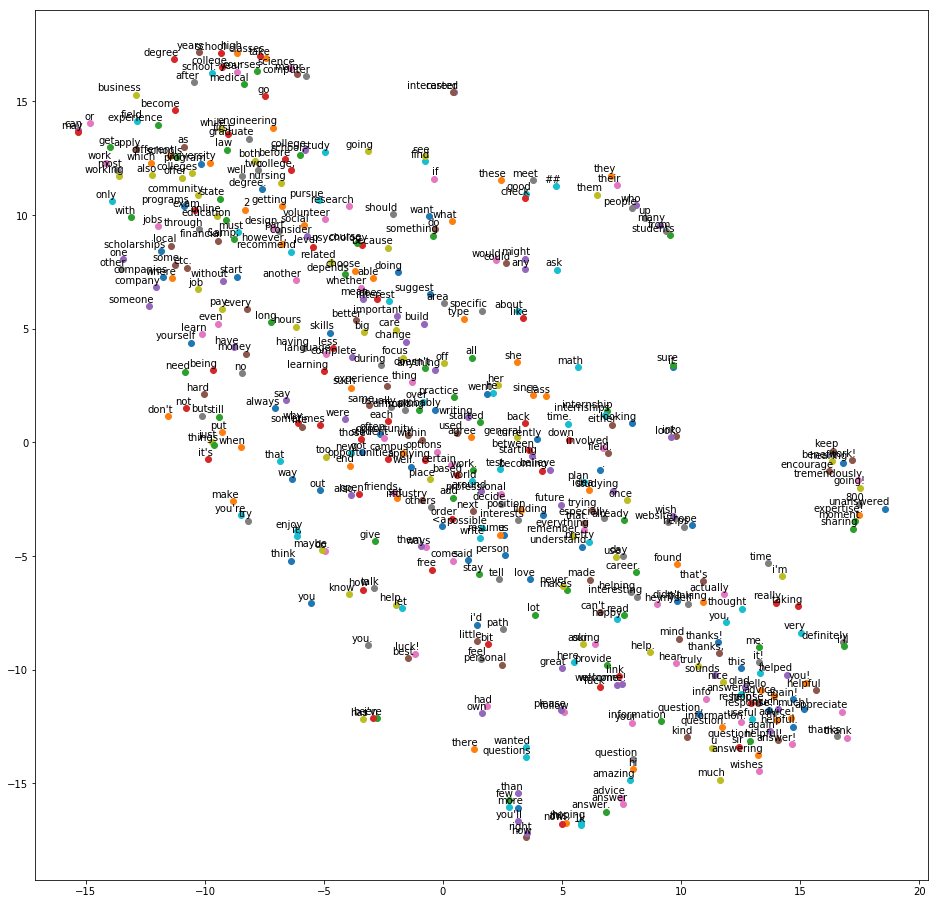

In [148]:
#https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
from gensim.models import word2vec
from sklearn.manifold import TSNE

corpus = []
stoplist = set("for a of the and to in on is are by its it so at s t am im i m an my be then was me will p we did i".split())

for a,b in (comments['comments_body']).iteritems():
    #print(a)
    #print(b.lower().split())
    #corpus.append([word for word in str(re.sub('[\W_]+', ' ', b)).lower().split() if word not in stoplist])
    #[word for word in str(b).lower().split() if word not in stoplist]
    corpus.append([word for word in str(b).lower().split() if word not in stoplist])


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   
model = word2vec.Word2Vec(corpus, size=300, window=20, min_count=100, workers=4)
tsne_plot(model)

In [149]:
from wordcloud import WordCloud, STOPWORDS

def wordCloudFunction(df,column,numWords):
    vectorizer = TfidfVectorizer(max_features=numWords, stop_words='english',ngram_range=(1,2))
    vector_comments = vectorizer.fit_transform(df[column].dropna())
    word_string = str(vectorizer.get_feature_names())
    indices = np.argsort(vectorizer.idf_)[::-1]
    top_n = 200
    #print(vectorizer.get_feature_names())
    top_features = [vectorizer.get_feature_names()[i] for i in indices]
    #print(top_features)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=numWords,
                          width=2000,height=1000,
                         ).generate(' '.join(top_features))
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


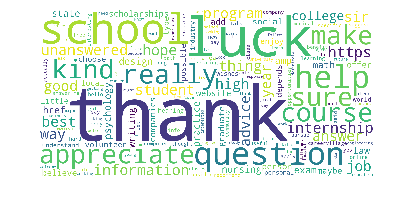

In [150]:
wordCloudFunction(comments,'comments_body',200)

['advice', 'answer', 'best', 'career', 'college', 'good', 'great', 'help', 'hi', 'information', 'know', 'like', 'question', 'really', 'school', 'thank', 'thanks', 'time', 'want', 'work']
[ 3  9  2 12 17 18 10  8  4 14 19 13  7  6 11  5  1  0 16 15]
['career', 'information', 'best', 'question', 'time', 'want', 'know', 'hi', 'college', 'school', 'work', 'really', 'help', 'great', 'like', 'good', 'answer', 'advice', 'thanks', 'thank']
career information best question time want know hi college school work really help great like good answer advice thanks thank


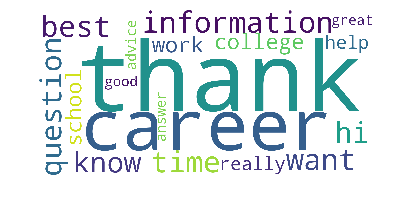

In [151]:
vectorizer = TfidfVectorizer(max_features=20, stop_words='english',ngram_range=(1,2))
vector_comments = vectorizer.fit_transform(comments['comments_body'].dropna())
print(vectorizer.get_feature_names())
indices = np.argsort(vectorizer.idf_)[::-1]
print(indices)
top_features = [vectorizer.get_feature_names()[i] for i in indices]
print(top_features)
print(' '.join(top_features))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=20,
                          width=2000,height=1000,
                         ).generate(' '.join(top_features))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [153]:
# comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'])

#https://stackoverflow.com/questions/16176996/keep-only-date-part-when-using-pandas-to-datetime
comments['just_date'] = comments['comments_date_added'].dt.date

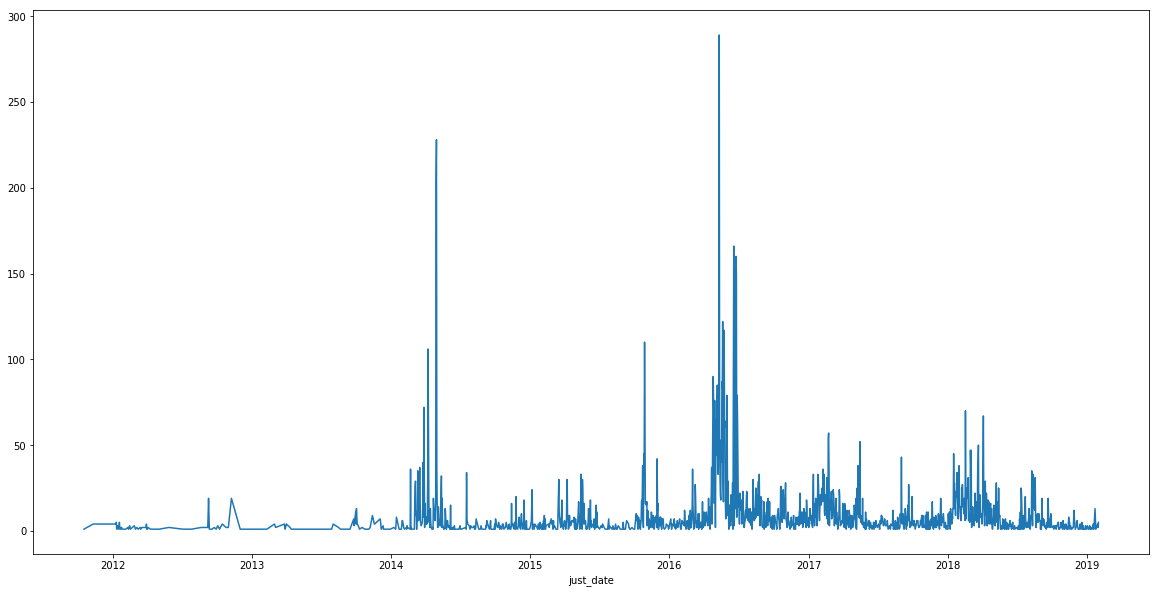

In [154]:
comments.groupby('just_date')['comments_id'].count().plot(figsize=(20,10))

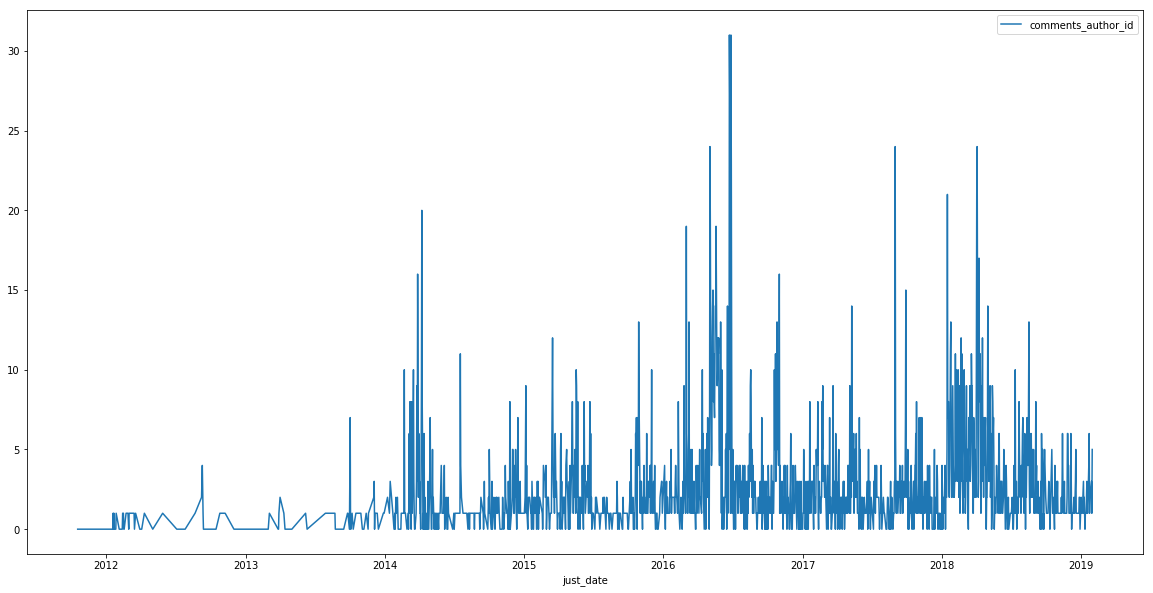

In [155]:
#https://stackoverflow.com/questions/46181475/python-pandas-groupby-date-and-count-new-records-for-each-period
#fig, ax = plt.subplots(figsize=(10,7))
#plt.figure(figsize=(20,10))
(comments
     .groupby(['comments_author_id'], as_index=False)['just_date']  # Group by `user_id` and get first date.
     .first()
     .groupby(['just_date'])  # Group result on `date` and take counts.
     .count()
     .reindex(comments['just_date'].unique())  # Reindex on original dates.
     .fillna(0)).plot(figsize=(20,10))

In [158]:
# school_memberships
print(school_memberships.head(2))
print(school_memberships.info())
#school_memberships.groups_group_type.value_counts().plot(kind='bar')

   school_memberships_school_id        school_memberships_user_id
0  197406                        23dce13ca6164a73aec7a3cd56a4884d
1  197398                        23dce13ca6164a73aec7a3cd56a4884d
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5638 entries, 0 to 5637
Data columns (total 2 columns):
school_memberships_school_id    5638 non-null int64
school_memberships_user_id      5638 non-null object
dtypes: int64(1), object(1)
memory usage: 88.2+ KB
None


                          groups_id groups_group_type
0  eabbdf4029734c848a9da20779637d03  youth program   
1  7080bf8dcf78463bb03e6863887fd715  youth program   


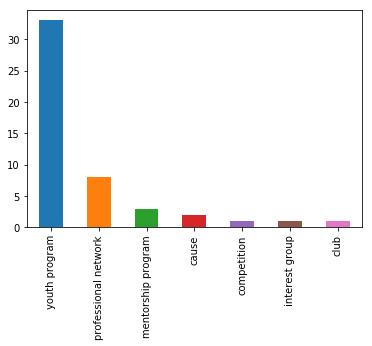

In [159]:
print(groups.head(2))
_ = groups.groups_group_type.value_counts().plot(kind='bar')

         group_memberships_group_id         group_memberships_user_id
0  eabbdf4029734c848a9da20779637d03  9a5aead62c344207b2624dba90985dc5
1  eabbdf4029734c848a9da20779637d03  ea7122da1c7b4244a2184a4f9f944053
                          groups_id groups_group_type  \
0  eabbdf4029734c848a9da20779637d03  youth program      
1  eabbdf4029734c848a9da20779637d03  youth program      

         group_memberships_group_id         group_memberships_user_id  
0  eabbdf4029734c848a9da20779637d03  9a5aead62c344207b2624dba90985dc5  
1  eabbdf4029734c848a9da20779637d03  ea7122da1c7b4244a2184a4f9f944053  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1037
Data columns (total 4 columns):
groups_id                     1038 non-null object
groups_group_type             1038 non-null object
group_memberships_group_id    1038 non-null object
group_memberships_user_id     1038 non-null object
dtypes: object(4)
memory usage: 40.5+ KB
None


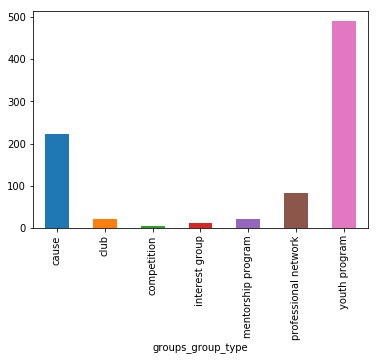

In [160]:
print(group_memberships.head(2))
grouptype_membership = groups.merge(right=group_memberships, how='inner', left_on='groups_id', right_on='group_memberships_group_id')
print(grouptype_membership.head(2))
_ = grouptype_membership[['groups_group_type', 'group_memberships_user_id']].groupby('groups_group_type')['group_memberships_user_id'].nunique().plot(kind='bar')
print(grouptype_membership.info())

Which days and months have students joining the most?

In [170]:
students.isnull().sum()

students_id                   0    
students_location             2033 
students_date_joined          0    
students_time_delta_joined    0    
students_questions_count      0    
students_comments_count       0    
date_last_question            18667
date_first_question           18667
date_last_comment             28248
date_first_comment            28248
date_last_activity            18150
date_first_activity           18150
students_questions_hearts     0    
students_tags                 26363
dtype: int64

KeyError: 'students_date_joined_month'

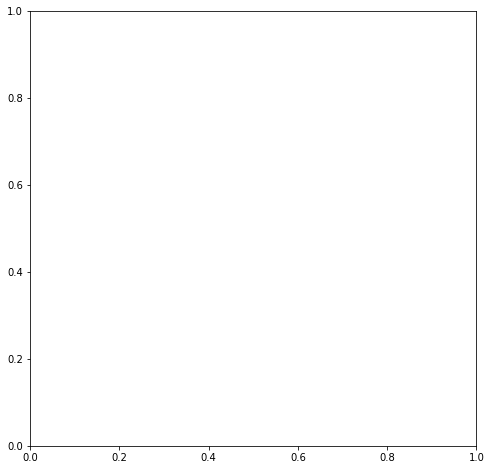

In [171]:
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(pd.crosstab(students['students_date_joined_month'],
                        students['students_date_joined_day_name']),
            annot=True,
            ax=ax, fmt='d', linewidths=0.1, cmap='PiYG')

In [183]:
newdata = pd.read_csv('career.csv')

In [193]:
newdata.head()

id  \
0  200842   
1  200769   
2  200723   
3  200721   
4  200718   

                                                                                                                                                                                                                   title  \
0  What is the most challenging part of being a Spanish teacher?                                                                                                                                                           
1  I have business studies ,coputer application technology acconting and mathematical literacy as my subjects are those enough or will i need to take a bridging course before i start studing to become a news anchor ?   
2  how  do i get my ged                                                                                                                                                                                                    
3  What steps would you recommend  I take to enter this field?                                                                                                                                                             
4  What should i know about being a Combat Medic?                                                                                                                                                                          

                                                                                                                                                                                                                                                                      question_body  \
0  #education #teacher                                                                                                                                                                                                                                                                
1  Hi i am lerato and 15 years of age i live in south africa .I think news is a very important role in our daily life . That is why i want to become a news anchor . Your response to my question will intend be helpful in my decision making. #journalism #business #entrepreneur   
2  i need ged #general                                                                                                                                                                                                                                                                
3  #medicine #healthcare #medical Assistant #hospital-and-health-care #doctor                                                                                                                                                                                                         
4  I'm a student at Job Corps still trying to figure out what i want as a career. I'm just asking so i have a clearer mind about my choices.  #medicalfield #army                                                                                                                     

                                                           tags answers  \
0  |education|teacher                                            NaN      
1  |journalism|business|entrepreneur                             NaN      
2  |general                                                      NaN      
3  |medicine|healthcare|medical|hospital-and-health-care|doctor  NaN      
4  |medicalfield|army                                            NaN      

   scores  \
0  0        
1  0        
2  0        
3  0        
4  0        

                                                                                                                                                                                                                                                                 url  
0  https://www.careervillage.org/questions/200842/what-is-the-most-challenging-part-of-being-a-spanish-teacher                             

In [185]:
newdata.shape

(5107, 7)

In [186]:
newdata.answers.isnull().sum()

952

In [192]:
newdata.scores.nlargest(5)

3839    123
3840    85 
3841    81 
3958    49 
1266    26 
Name: scores, dtype: int64

In [194]:
questions.questions_id

0        332a511f1569444485cf7a7a556a5e54
1        eb80205482e4424cad8f16bc25aa2d9c
2        4ec31632938a40b98909416bdd0decff
3        2f6a9a99d9b24e5baa50d40d0ba50a75
4        5af8880460c141dbb02971a1a8369529
5        7c336403258f4da3a2e0955742c76462
6        be3c5edfdb07423e955e9b2d7f186bce
7        0f1d6a4f276c4a05878dd48e03e52289
8        d4999cdc470049a1a3382c4b5f14a7aa
9        e214acfbe6644d65b889a3268828db9d
10       6351c23f2e144b359c3301d40b3d81ef
11       a978f83b826c4fba80cbef96f16777cd
12       63171d8c2d3f4a8c9100b0bfcb062195
13       fecd4c7f68144042abca8672b6114a36
14       baa937b4cd184a22acfd76249d25042c
15       eb0027b3dcd04d88b76a493fc1558c15
16       be0bac33e0594b21ac1f82fe2ffac7fb
17       5cf8f5929e1c4357af4b467d4537dcef
18       f156171f9c4944de99c1ab974cb7558d
19       fb615cf6770d4b7b92173d3210036df2
20       c1b82814b0274452873428b9db923939
21       f05b579f2cd3432898f3ba54feee86b6
22       914d40e5d2cd41baace8320541e23b0f
23       205e5d1d3db3473c85c3b3ccc